# Somovbody once told me! : В машинном обучении твоя сила и мудрость!
![image info](./photo_2021-05-20_11-30-12.jpg)

In [250]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

In [48]:
train = pd.read_csv('kaggle_train_churn.csv') 
test = pd.read_csv('kaggle_test_churn.csv')

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         5282 non-null   object 
 1   Count              5282 non-null   int64  
 2   Country            5282 non-null   object 
 3   State              5282 non-null   object 
 4   City               5282 non-null   object 
 5   Zip Code           5282 non-null   int64  
 6   Lat Long           5282 non-null   object 
 7   Latitude           5282 non-null   float64
 8   Longitude          5282 non-null   float64
 9   Gender             5282 non-null   object 
 10  Senior Citizen     5282 non-null   object 
 11  Partner            5282 non-null   object 
 12  Dependents         5282 non-null   object 
 13  Tenure Months      5282 non-null   int64  
 14  Phone Service      5282 non-null   object 
 15  Multiple Lines     5282 non-null   object 
 16  Internet Service   5282 

In [139]:
train.head(10)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Score,CLTV,Churn Reason,Churn Value
0,2995-YWTCD,1,United States,California,Browns Valley,95918,"39.292334, -121.320597",39.292334,-121.320597,Female,...,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),24.90,79,5396,Unknow,0
1,3318-ISQFQ,1,United States,California,Newark,94560,"37.504133, -122.032347",37.504133,-122.032347,Female,...,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),19.50,28,5409,Unknow,0
2,2469-DTSGX,1,United States,California,Somis,93066,"34.297628, -119.014627",34.297628,-119.014627,Female,...,Yes,Yes,Two year,No,Electronic check,111.65,75,5388,Unknow,0
3,8896-BQTTI,1,United States,California,Cool,95614,"38.880622, -120.973865",38.880622,-120.973865,Male,...,No internet service,No internet service,Month-to-month,Yes,Mailed check,25.00,53,2371,Unknow,0
4,9565-DJPIB,1,United States,California,Vallejo,94590,"38.104705, -122.247387",38.104705,-122.247387,Female,...,Yes,No,Month-to-month,No,Mailed check,89.60,87,4689,Network reliability,1
5,0363-QJVFX,1,United States,California,Lake Hughes,93532,"34.659579, -118.584212",34.659579,-118.584212,Male,...,Yes,Yes,Month-to-month,Yes,Credit card (automatic),108.15,69,2541,Attitude of service provider,1
6,5602-BVFMK,1,United States,California,Independence,93526,"36.869584, -118.189241",36.869584,-118.189241,Female,...,No internet service,No internet service,One year,No,Mailed check,19.30,77,2868,Unknow,0
7,5847-MXBEO,1,United States,California,Helm,93627,"36.520537, -120.118055",36.520537,-120.118055,Male,...,No internet service,No internet service,One year,No,Mailed check,20.30,50,4510,Unknow,0
8,9214-EKVXR,1,United States,California,San Francisco,94110,"37.750021, -122.415201",37.750021,-122.415201,Female,...,No,No,Month-to-month,Yes,Mailed check,44.00,75,4138,Unknow,0
9,7752-XUSCI,1,United States,California,Crestline,92325,"34.248061, -117.29028",34.248061,-117.290280,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,105.90,84,4105,Don't know,1


In [138]:
set(train['Contract'])

{'Month-to-month', 'One year', 'Two year'}

Заполним неизвестную причину как 'Unknow'

In [51]:
train['Churn Reason'].fillna('Unknow', inplace=True)

Counter({0: 3912, 1: 1370})


array([[<AxesSubplot:title={'center':'Churn Value'}>]], dtype=object)

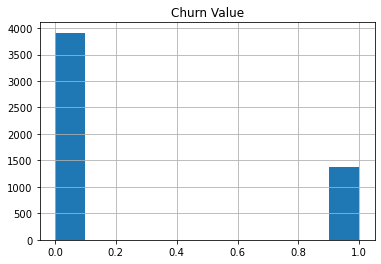

In [52]:
from collections import Counter

counter = Counter(train['Churn Value'])
print(counter)

train.hist(column='Churn Value', )

In [140]:
analysis_features = ['Churn Score', 'CLTV', 'Churn Reason']
target_feature = 'Churn Value'

In [141]:
train_features = set(train.columns) - set(analysis_features) - set([target_feature])

Есть ещё признаки, которые можно убрать из обучающей выборки. Во-первых, CustomerID - это уникальный ID для каждого пользователя . Также можно убрать признак Lat Long, тк это просто обьединение 2-х признаков Latitude и Longitude

In [142]:
train_features -= set(['CustomerID', 'Lat Long'])
train_features -= set(['Country', 'State'])

In [143]:
cat_features = set(train_features) - set(['Monthly Charges', 'Count', 'Zip Code', 'Latitude', 'Longitude', 'Tenure Months'])

In [144]:
len(train_features)

23

In [43]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         1761 non-null   object 
 1   Count              1761 non-null   int64  
 2   Country            1761 non-null   object 
 3   State              1761 non-null   object 
 4   City               1761 non-null   object 
 5   Zip Code           1761 non-null   int64  
 6   Lat Long           1761 non-null   object 
 7   Latitude           1761 non-null   float64
 8   Longitude          1761 non-null   float64
 9   Gender             1761 non-null   object 
 10  Senior Citizen     1761 non-null   object 
 11  Partner            1761 non-null   object 
 12  Dependents         1761 non-null   object 
 13  Tenure Months      1761 non-null   int64  
 14  Phone Service      1761 non-null   object 
 15  Multiple Lines     1761 non-null   object 
 16  Internet Service   1761 

In [235]:
X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(train[train_features], train[target_feature], 
                                                  test_size=0.2, random_state=42, stratify=train[target_feature])

## Classification model

In [236]:
model_clf = CatBoostClassifier(cat_features=cat_features)

cv = cross_val_score(model_clf, X_train_clf, y_train_clf, cv=5, scoring='roc_auc')
cv.mean()

Learning rate set to 0.017329
0:	learn: 0.6814399	total: 32.3ms	remaining: 32.3s
1:	learn: 0.6711361	total: 60.3ms	remaining: 30.1s
2:	learn: 0.6573772	total: 92.9ms	remaining: 30.9s
3:	learn: 0.6471135	total: 123ms	remaining: 30.6s
4:	learn: 0.6371450	total: 158ms	remaining: 31.4s
5:	learn: 0.6283781	total: 176ms	remaining: 29.2s
6:	learn: 0.6193297	total: 220ms	remaining: 31.2s
7:	learn: 0.6113677	total: 254ms	remaining: 31.6s
8:	learn: 0.6031302	total: 286ms	remaining: 31.5s
9:	learn: 0.5957810	total: 322ms	remaining: 31.9s
10:	learn: 0.5883124	total: 355ms	remaining: 31.9s
11:	learn: 0.5817617	total: 387ms	remaining: 31.9s
12:	learn: 0.5767523	total: 421ms	remaining: 31.9s
13:	learn: 0.5703887	total: 457ms	remaining: 32.2s
14:	learn: 0.5643339	total: 477ms	remaining: 31.3s
15:	learn: 0.5578613	total: 509ms	remaining: 31.3s
16:	learn: 0.5530942	total: 526ms	remaining: 30.4s
17:	learn: 0.5457730	total: 564ms	remaining: 30.8s
18:	learn: 0.5407257	total: 595ms	remaining: 30.7s
19:	lear

165:	learn: 0.3807467	total: 5.96s	remaining: 30s
166:	learn: 0.3804021	total: 6s	remaining: 29.9s
167:	learn: 0.3802980	total: 6.03s	remaining: 29.9s
168:	learn: 0.3801328	total: 6.06s	remaining: 29.8s
169:	learn: 0.3800017	total: 6.1s	remaining: 29.8s
170:	learn: 0.3798424	total: 6.15s	remaining: 29.8s
171:	learn: 0.3795838	total: 6.21s	remaining: 29.9s
172:	learn: 0.3791763	total: 6.25s	remaining: 29.9s
173:	learn: 0.3787781	total: 6.31s	remaining: 30s
174:	learn: 0.3786870	total: 6.36s	remaining: 30s
175:	learn: 0.3784357	total: 6.42s	remaining: 30.1s
176:	learn: 0.3781664	total: 6.48s	remaining: 30.1s
177:	learn: 0.3780303	total: 6.52s	remaining: 30.1s
178:	learn: 0.3779721	total: 6.55s	remaining: 30.1s
179:	learn: 0.3778631	total: 6.59s	remaining: 30s
180:	learn: 0.3775723	total: 6.63s	remaining: 30s
181:	learn: 0.3774792	total: 6.66s	remaining: 29.9s
182:	learn: 0.3773466	total: 6.69s	remaining: 29.9s
183:	learn: 0.3772280	total: 6.72s	remaining: 29.8s
184:	learn: 0.3767683	tota

324:	learn: 0.3580776	total: 11.4s	remaining: 23.7s
325:	learn: 0.3579772	total: 11.4s	remaining: 23.6s
326:	learn: 0.3578514	total: 11.5s	remaining: 23.6s
327:	learn: 0.3577789	total: 11.5s	remaining: 23.5s
328:	learn: 0.3575623	total: 11.5s	remaining: 23.5s
329:	learn: 0.3574106	total: 11.6s	remaining: 23.5s
330:	learn: 0.3570965	total: 11.6s	remaining: 23.4s
331:	learn: 0.3570495	total: 11.6s	remaining: 23.4s
332:	learn: 0.3569533	total: 11.7s	remaining: 23.4s
333:	learn: 0.3568119	total: 11.7s	remaining: 23.3s
334:	learn: 0.3567585	total: 11.7s	remaining: 23.3s
335:	learn: 0.3566473	total: 11.8s	remaining: 23.3s
336:	learn: 0.3565455	total: 11.8s	remaining: 23.2s
337:	learn: 0.3564467	total: 11.8s	remaining: 23.2s
338:	learn: 0.3563418	total: 11.9s	remaining: 23.2s
339:	learn: 0.3561787	total: 11.9s	remaining: 23.1s
340:	learn: 0.3560026	total: 11.9s	remaining: 23.1s
341:	learn: 0.3559102	total: 12s	remaining: 23s
342:	learn: 0.3558952	total: 12s	remaining: 23s
343:	learn: 0.355893

486:	learn: 0.3401514	total: 16.9s	remaining: 17.8s
487:	learn: 0.3401475	total: 16.9s	remaining: 17.8s
488:	learn: 0.3400318	total: 17s	remaining: 17.7s
489:	learn: 0.3399228	total: 17s	remaining: 17.7s
490:	learn: 0.3398017	total: 17s	remaining: 17.7s
491:	learn: 0.3395822	total: 17.1s	remaining: 17.6s
492:	learn: 0.3395658	total: 17.1s	remaining: 17.6s
493:	learn: 0.3394144	total: 17.2s	remaining: 17.6s
494:	learn: 0.3393079	total: 17.2s	remaining: 17.6s
495:	learn: 0.3392094	total: 17.3s	remaining: 17.6s
496:	learn: 0.3391176	total: 17.4s	remaining: 17.6s
497:	learn: 0.3389637	total: 17.4s	remaining: 17.5s
498:	learn: 0.3389236	total: 17.4s	remaining: 17.5s
499:	learn: 0.3388241	total: 17.5s	remaining: 17.5s
500:	learn: 0.3386154	total: 17.5s	remaining: 17.4s
501:	learn: 0.3385563	total: 17.6s	remaining: 17.4s
502:	learn: 0.3384414	total: 17.6s	remaining: 17.4s
503:	learn: 0.3384174	total: 17.6s	remaining: 17.3s
504:	learn: 0.3383385	total: 17.7s	remaining: 17.3s
505:	learn: 0.3380

647:	learn: 0.3225100	total: 23.3s	remaining: 12.7s
648:	learn: 0.3224453	total: 23.3s	remaining: 12.6s
649:	learn: 0.3223361	total: 23.4s	remaining: 12.6s
650:	learn: 0.3221796	total: 23.4s	remaining: 12.5s
651:	learn: 0.3221455	total: 23.4s	remaining: 12.5s
652:	learn: 0.3220170	total: 23.5s	remaining: 12.5s
653:	learn: 0.3219295	total: 23.5s	remaining: 12.4s
654:	learn: 0.3218623	total: 23.5s	remaining: 12.4s
655:	learn: 0.3217520	total: 23.6s	remaining: 12.4s
656:	learn: 0.3216978	total: 23.6s	remaining: 12.3s
657:	learn: 0.3216120	total: 23.6s	remaining: 12.3s
658:	learn: 0.3215477	total: 23.7s	remaining: 12.2s
659:	learn: 0.3214450	total: 23.7s	remaining: 12.2s
660:	learn: 0.3213184	total: 23.7s	remaining: 12.2s
661:	learn: 0.3212145	total: 23.8s	remaining: 12.1s
662:	learn: 0.3211556	total: 23.8s	remaining: 12.1s
663:	learn: 0.3210984	total: 23.8s	remaining: 12.1s
664:	learn: 0.3210770	total: 23.9s	remaining: 12s
665:	learn: 0.3209441	total: 23.9s	remaining: 12s
666:	learn: 0.32

807:	learn: 0.3057676	total: 29.3s	remaining: 6.96s
808:	learn: 0.3057125	total: 29.3s	remaining: 6.92s
809:	learn: 0.3055230	total: 29.3s	remaining: 6.88s
810:	learn: 0.3054240	total: 29.4s	remaining: 6.85s
811:	learn: 0.3053836	total: 29.4s	remaining: 6.81s
812:	learn: 0.3053053	total: 29.5s	remaining: 6.77s
813:	learn: 0.3052656	total: 29.5s	remaining: 6.74s
814:	learn: 0.3049269	total: 29.5s	remaining: 6.7s
815:	learn: 0.3049004	total: 29.6s	remaining: 6.66s
816:	learn: 0.3048395	total: 29.6s	remaining: 6.63s
817:	learn: 0.3048116	total: 29.6s	remaining: 6.59s
818:	learn: 0.3046046	total: 29.7s	remaining: 6.56s
819:	learn: 0.3045874	total: 29.7s	remaining: 6.52s
820:	learn: 0.3044271	total: 29.7s	remaining: 6.49s
821:	learn: 0.3042587	total: 29.8s	remaining: 6.45s
822:	learn: 0.3042103	total: 29.8s	remaining: 6.41s
823:	learn: 0.3041954	total: 29.9s	remaining: 6.38s
824:	learn: 0.3040676	total: 29.9s	remaining: 6.34s
825:	learn: 0.3039756	total: 29.9s	remaining: 6.3s
826:	learn: 0.

970:	learn: 0.2892277	total: 35.2s	remaining: 1.05s
971:	learn: 0.2891900	total: 35.3s	remaining: 1.02s
972:	learn: 0.2890108	total: 35.3s	remaining: 980ms
973:	learn: 0.2889894	total: 35.4s	remaining: 944ms
974:	learn: 0.2889305	total: 35.4s	remaining: 908ms
975:	learn: 0.2888435	total: 35.4s	remaining: 871ms
976:	learn: 0.2887389	total: 35.5s	remaining: 835ms
977:	learn: 0.2885759	total: 35.5s	remaining: 799ms
978:	learn: 0.2885315	total: 35.5s	remaining: 762ms
979:	learn: 0.2884593	total: 35.6s	remaining: 726ms
980:	learn: 0.2884219	total: 35.6s	remaining: 690ms
981:	learn: 0.2882643	total: 35.6s	remaining: 653ms
982:	learn: 0.2882187	total: 35.7s	remaining: 617ms
983:	learn: 0.2881746	total: 35.7s	remaining: 581ms
984:	learn: 0.2881400	total: 35.8s	remaining: 544ms
985:	learn: 0.2880637	total: 35.8s	remaining: 508ms
986:	learn: 0.2879368	total: 35.8s	remaining: 472ms
987:	learn: 0.2877585	total: 35.9s	remaining: 436ms
988:	learn: 0.2876907	total: 35.9s	remaining: 399ms
989:	learn: 

136:	learn: 0.3849936	total: 4.48s	remaining: 28.2s
137:	learn: 0.3849242	total: 4.49s	remaining: 28.1s
138:	learn: 0.3846961	total: 4.54s	remaining: 28.1s
139:	learn: 0.3843153	total: 4.57s	remaining: 28.1s
140:	learn: 0.3839172	total: 4.61s	remaining: 28.1s
141:	learn: 0.3838160	total: 4.65s	remaining: 28.1s
142:	learn: 0.3835174	total: 4.69s	remaining: 28.1s
143:	learn: 0.3834964	total: 4.7s	remaining: 28s
144:	learn: 0.3831270	total: 4.74s	remaining: 27.9s
145:	learn: 0.3827659	total: 4.77s	remaining: 27.9s
146:	learn: 0.3824615	total: 4.8s	remaining: 27.8s
147:	learn: 0.3822108	total: 4.83s	remaining: 27.8s
148:	learn: 0.3821513	total: 4.84s	remaining: 27.7s
149:	learn: 0.3818343	total: 4.88s	remaining: 27.7s
150:	learn: 0.3815817	total: 4.92s	remaining: 27.6s
151:	learn: 0.3814051	total: 4.95s	remaining: 27.6s
152:	learn: 0.3812265	total: 4.98s	remaining: 27.6s
153:	learn: 0.3809340	total: 5.01s	remaining: 27.5s
154:	learn: 0.3807792	total: 5.05s	remaining: 27.5s
155:	learn: 0.38

295:	learn: 0.3597741	total: 9.67s	remaining: 23s
296:	learn: 0.3597029	total: 9.7s	remaining: 23s
297:	learn: 0.3596198	total: 9.73s	remaining: 22.9s
298:	learn: 0.3593717	total: 9.77s	remaining: 22.9s
299:	learn: 0.3592197	total: 9.8s	remaining: 22.9s
300:	learn: 0.3591169	total: 9.84s	remaining: 22.8s
301:	learn: 0.3590866	total: 9.85s	remaining: 22.8s
302:	learn: 0.3590823	total: 9.86s	remaining: 22.7s
303:	learn: 0.3589076	total: 9.89s	remaining: 22.7s
304:	learn: 0.3587509	total: 9.93s	remaining: 22.6s
305:	learn: 0.3585096	total: 9.96s	remaining: 22.6s
306:	learn: 0.3583829	total: 9.99s	remaining: 22.6s
307:	learn: 0.3581855	total: 10s	remaining: 22.5s
308:	learn: 0.3580915	total: 10.1s	remaining: 22.5s
309:	learn: 0.3577496	total: 10.1s	remaining: 22.5s
310:	learn: 0.3576748	total: 10.1s	remaining: 22.4s
311:	learn: 0.3573344	total: 10.2s	remaining: 22.4s
312:	learn: 0.3572374	total: 10.2s	remaining: 22.4s
313:	learn: 0.3571835	total: 10.2s	remaining: 22.3s
314:	learn: 0.357161

459:	learn: 0.3403864	total: 15.3s	remaining: 18s
460:	learn: 0.3401841	total: 15.3s	remaining: 17.9s
461:	learn: 0.3401237	total: 15.4s	remaining: 17.9s
462:	learn: 0.3398896	total: 15.4s	remaining: 17.9s
463:	learn: 0.3397308	total: 15.5s	remaining: 17.9s
464:	learn: 0.3395541	total: 15.5s	remaining: 17.8s
465:	learn: 0.3394152	total: 15.5s	remaining: 17.8s
466:	learn: 0.3393064	total: 15.6s	remaining: 17.8s
467:	learn: 0.3391998	total: 15.6s	remaining: 17.7s
468:	learn: 0.3390957	total: 15.6s	remaining: 17.7s
469:	learn: 0.3389034	total: 15.7s	remaining: 17.7s
470:	learn: 0.3386592	total: 15.7s	remaining: 17.6s
471:	learn: 0.3384971	total: 15.8s	remaining: 17.6s
472:	learn: 0.3384782	total: 15.8s	remaining: 17.6s
473:	learn: 0.3382538	total: 15.9s	remaining: 17.6s
474:	learn: 0.3380765	total: 15.9s	remaining: 17.6s
475:	learn: 0.3379529	total: 16s	remaining: 17.6s
476:	learn: 0.3379014	total: 16s	remaining: 17.6s
477:	learn: 0.3377090	total: 16.1s	remaining: 17.5s
478:	learn: 0.3374

621:	learn: 0.3203215	total: 21.4s	remaining: 13s
622:	learn: 0.3202633	total: 21.4s	remaining: 13s
623:	learn: 0.3202053	total: 21.5s	remaining: 12.9s
624:	learn: 0.3201163	total: 21.5s	remaining: 12.9s
625:	learn: 0.3200381	total: 21.5s	remaining: 12.9s
626:	learn: 0.3199454	total: 21.6s	remaining: 12.8s
627:	learn: 0.3198432	total: 21.6s	remaining: 12.8s
628:	learn: 0.3196649	total: 21.7s	remaining: 12.8s
629:	learn: 0.3195744	total: 21.7s	remaining: 12.7s
630:	learn: 0.3195582	total: 21.7s	remaining: 12.7s
631:	learn: 0.3191926	total: 21.8s	remaining: 12.7s
632:	learn: 0.3190289	total: 21.8s	remaining: 12.6s
633:	learn: 0.3189597	total: 21.8s	remaining: 12.6s
634:	learn: 0.3188222	total: 21.9s	remaining: 12.6s
635:	learn: 0.3186666	total: 21.9s	remaining: 12.5s
636:	learn: 0.3186201	total: 21.9s	remaining: 12.5s
637:	learn: 0.3184993	total: 22s	remaining: 12.5s
638:	learn: 0.3183523	total: 22s	remaining: 12.4s
639:	learn: 0.3180623	total: 22s	remaining: 12.4s
640:	learn: 0.3180236	

786:	learn: 0.3032243	total: 27.3s	remaining: 7.39s
787:	learn: 0.3030854	total: 27.4s	remaining: 7.36s
788:	learn: 0.3030061	total: 27.4s	remaining: 7.33s
789:	learn: 0.3029214	total: 27.4s	remaining: 7.29s
790:	learn: 0.3028977	total: 27.5s	remaining: 7.26s
791:	learn: 0.3028298	total: 27.5s	remaining: 7.22s
792:	learn: 0.3027929	total: 27.5s	remaining: 7.19s
793:	learn: 0.3025990	total: 27.6s	remaining: 7.15s
794:	learn: 0.3025535	total: 27.6s	remaining: 7.12s
795:	learn: 0.3025045	total: 27.6s	remaining: 7.08s
796:	learn: 0.3024421	total: 27.7s	remaining: 7.05s
797:	learn: 0.3024044	total: 27.7s	remaining: 7.01s
798:	learn: 0.3023877	total: 27.7s	remaining: 6.98s
799:	learn: 0.3023161	total: 27.8s	remaining: 6.94s
800:	learn: 0.3021998	total: 27.8s	remaining: 6.91s
801:	learn: 0.3019235	total: 27.8s	remaining: 6.87s
802:	learn: 0.3018943	total: 27.9s	remaining: 6.84s
803:	learn: 0.3018315	total: 27.9s	remaining: 6.8s
804:	learn: 0.3016219	total: 27.9s	remaining: 6.77s
805:	learn: 0

945:	learn: 0.2871219	total: 32.9s	remaining: 1.88s
946:	learn: 0.2870694	total: 33s	remaining: 1.84s
947:	learn: 0.2869440	total: 33s	remaining: 1.81s
948:	learn: 0.2868989	total: 33s	remaining: 1.77s
949:	learn: 0.2868639	total: 33.1s	remaining: 1.74s
950:	learn: 0.2867762	total: 33.1s	remaining: 1.71s
951:	learn: 0.2866727	total: 33.1s	remaining: 1.67s
952:	learn: 0.2865948	total: 33.2s	remaining: 1.64s
953:	learn: 0.2864056	total: 33.2s	remaining: 1.6s
954:	learn: 0.2863195	total: 33.2s	remaining: 1.57s
955:	learn: 0.2862745	total: 33.3s	remaining: 1.53s
956:	learn: 0.2862418	total: 33.3s	remaining: 1.5s
957:	learn: 0.2861462	total: 33.4s	remaining: 1.46s
958:	learn: 0.2860587	total: 33.4s	remaining: 1.43s
959:	learn: 0.2859792	total: 33.4s	remaining: 1.39s
960:	learn: 0.2858474	total: 33.5s	remaining: 1.36s
961:	learn: 0.2857372	total: 33.5s	remaining: 1.32s
962:	learn: 0.2857055	total: 33.5s	remaining: 1.29s
963:	learn: 0.2856255	total: 33.6s	remaining: 1.25s
964:	learn: 0.285349

110:	learn: 0.3889040	total: 3.72s	remaining: 29.8s
111:	learn: 0.3883408	total: 3.75s	remaining: 29.8s
112:	learn: 0.3877778	total: 3.78s	remaining: 29.7s
113:	learn: 0.3872743	total: 3.82s	remaining: 29.7s
114:	learn: 0.3866089	total: 3.85s	remaining: 29.7s
115:	learn: 0.3865011	total: 3.87s	remaining: 29.5s
116:	learn: 0.3861340	total: 3.9s	remaining: 29.5s
117:	learn: 0.3857568	total: 3.94s	remaining: 29.5s
118:	learn: 0.3855197	total: 3.99s	remaining: 29.5s
119:	learn: 0.3851938	total: 4.02s	remaining: 29.5s
120:	learn: 0.3847841	total: 4.05s	remaining: 29.5s
121:	learn: 0.3840864	total: 4.1s	remaining: 29.5s
122:	learn: 0.3838881	total: 4.14s	remaining: 29.5s
123:	learn: 0.3835234	total: 4.18s	remaining: 29.5s
124:	learn: 0.3834422	total: 4.19s	remaining: 29.3s
125:	learn: 0.3831925	total: 4.23s	remaining: 29.3s
126:	learn: 0.3827570	total: 4.26s	remaining: 29.3s
127:	learn: 0.3824098	total: 4.29s	remaining: 29.3s
128:	learn: 0.3820847	total: 4.34s	remaining: 29.3s
129:	learn: 0.

273:	learn: 0.3565220	total: 9.34s	remaining: 24.8s
274:	learn: 0.3564175	total: 9.38s	remaining: 24.7s
275:	learn: 0.3563527	total: 9.41s	remaining: 24.7s
276:	learn: 0.3562964	total: 9.45s	remaining: 24.7s
277:	learn: 0.3562149	total: 9.48s	remaining: 24.6s
278:	learn: 0.3560869	total: 9.51s	remaining: 24.6s
279:	learn: 0.3560411	total: 9.53s	remaining: 24.5s
280:	learn: 0.3560364	total: 9.56s	remaining: 24.5s
281:	learn: 0.3556740	total: 9.59s	remaining: 24.4s
282:	learn: 0.3554802	total: 9.62s	remaining: 24.4s
283:	learn: 0.3554755	total: 9.65s	remaining: 24.3s
284:	learn: 0.3553605	total: 9.68s	remaining: 24.3s
285:	learn: 0.3552063	total: 9.72s	remaining: 24.3s
286:	learn: 0.3551977	total: 9.73s	remaining: 24.2s
287:	learn: 0.3551517	total: 9.75s	remaining: 24.1s
288:	learn: 0.3550523	total: 9.79s	remaining: 24.1s
289:	learn: 0.3548518	total: 9.83s	remaining: 24.1s
290:	learn: 0.3546540	total: 9.86s	remaining: 24s
291:	learn: 0.3544396	total: 9.9s	remaining: 24s
292:	learn: 0.354

437:	learn: 0.3375050	total: 14.5s	remaining: 18.7s
438:	learn: 0.3373157	total: 14.6s	remaining: 18.6s
439:	learn: 0.3371990	total: 14.6s	remaining: 18.6s
440:	learn: 0.3371583	total: 14.6s	remaining: 18.6s
441:	learn: 0.3369352	total: 14.7s	remaining: 18.5s
442:	learn: 0.3368394	total: 14.7s	remaining: 18.5s
443:	learn: 0.3367511	total: 14.7s	remaining: 18.5s
444:	learn: 0.3366610	total: 14.8s	remaining: 18.4s
445:	learn: 0.3365482	total: 14.8s	remaining: 18.4s
446:	learn: 0.3363841	total: 14.8s	remaining: 18.4s
447:	learn: 0.3362735	total: 14.9s	remaining: 18.3s
448:	learn: 0.3361226	total: 14.9s	remaining: 18.3s
449:	learn: 0.3359762	total: 15s	remaining: 18.3s
450:	learn: 0.3359602	total: 15s	remaining: 18.3s
451:	learn: 0.3358243	total: 15.1s	remaining: 18.3s
452:	learn: 0.3355156	total: 15.1s	remaining: 18.2s
453:	learn: 0.3353031	total: 15.1s	remaining: 18.2s
454:	learn: 0.3351389	total: 15.2s	remaining: 18.2s
455:	learn: 0.3350924	total: 15.2s	remaining: 18.1s
456:	learn: 0.33

600:	learn: 0.3187070	total: 20.2s	remaining: 13.4s
601:	learn: 0.3185375	total: 20.2s	remaining: 13.4s
602:	learn: 0.3184517	total: 20.2s	remaining: 13.3s
603:	learn: 0.3183258	total: 20.3s	remaining: 13.3s
604:	learn: 0.3181131	total: 20.3s	remaining: 13.3s
605:	learn: 0.3180097	total: 20.3s	remaining: 13.2s
606:	learn: 0.3179320	total: 20.4s	remaining: 13.2s
607:	learn: 0.3179165	total: 20.4s	remaining: 13.2s
608:	learn: 0.3178618	total: 20.5s	remaining: 13.1s
609:	learn: 0.3177600	total: 20.5s	remaining: 13.1s
610:	learn: 0.3176827	total: 20.5s	remaining: 13.1s
611:	learn: 0.3175512	total: 20.6s	remaining: 13s
612:	learn: 0.3173501	total: 20.6s	remaining: 13s
613:	learn: 0.3172372	total: 20.6s	remaining: 13s
614:	learn: 0.3170974	total: 20.7s	remaining: 12.9s
615:	learn: 0.3168955	total: 20.7s	remaining: 12.9s
616:	learn: 0.3168313	total: 20.7s	remaining: 12.9s
617:	learn: 0.3167580	total: 20.8s	remaining: 12.8s
618:	learn: 0.3166540	total: 20.8s	remaining: 12.8s
619:	learn: 0.3165

759:	learn: 0.2999290	total: 25.7s	remaining: 8.11s
760:	learn: 0.2997376	total: 25.7s	remaining: 8.08s
761:	learn: 0.2996449	total: 25.7s	remaining: 8.04s
762:	learn: 0.2994938	total: 25.8s	remaining: 8.01s
763:	learn: 0.2994050	total: 25.8s	remaining: 7.97s
764:	learn: 0.2992060	total: 25.9s	remaining: 7.94s
765:	learn: 0.2991501	total: 25.9s	remaining: 7.91s
766:	learn: 0.2990135	total: 25.9s	remaining: 7.88s
767:	learn: 0.2988999	total: 26s	remaining: 7.85s
768:	learn: 0.2987709	total: 26s	remaining: 7.82s
769:	learn: 0.2987587	total: 26.1s	remaining: 7.78s
770:	learn: 0.2987124	total: 26.1s	remaining: 7.75s
771:	learn: 0.2985829	total: 26.1s	remaining: 7.71s
772:	learn: 0.2985390	total: 26.2s	remaining: 7.68s
773:	learn: 0.2984157	total: 26.2s	remaining: 7.65s
774:	learn: 0.2981920	total: 26.2s	remaining: 7.61s
775:	learn: 0.2980336	total: 26.3s	remaining: 7.58s
776:	learn: 0.2979862	total: 26.3s	remaining: 7.54s
777:	learn: 0.2979152	total: 26.3s	remaining: 7.51s
778:	learn: 0.29

918:	learn: 0.2831453	total: 32.2s	remaining: 2.84s
919:	learn: 0.2830820	total: 32.2s	remaining: 2.8s
920:	learn: 0.2830301	total: 32.3s	remaining: 2.77s
921:	learn: 0.2829103	total: 32.3s	remaining: 2.73s
922:	learn: 0.2827536	total: 32.4s	remaining: 2.7s
923:	learn: 0.2827155	total: 32.4s	remaining: 2.67s
924:	learn: 0.2825874	total: 32.5s	remaining: 2.63s
925:	learn: 0.2824554	total: 32.5s	remaining: 2.6s
926:	learn: 0.2823425	total: 32.5s	remaining: 2.56s
927:	learn: 0.2821829	total: 32.6s	remaining: 2.53s
928:	learn: 0.2819907	total: 32.6s	remaining: 2.49s
929:	learn: 0.2818618	total: 32.6s	remaining: 2.46s
930:	learn: 0.2817539	total: 32.7s	remaining: 2.42s
931:	learn: 0.2817068	total: 32.7s	remaining: 2.39s
932:	learn: 0.2816311	total: 32.8s	remaining: 2.35s
933:	learn: 0.2815509	total: 32.8s	remaining: 2.32s
934:	learn: 0.2814903	total: 32.8s	remaining: 2.28s
935:	learn: 0.2814701	total: 32.9s	remaining: 2.25s
936:	learn: 0.2813772	total: 32.9s	remaining: 2.21s
937:	learn: 0.2

85:	learn: 0.4175549	total: 3.1s	remaining: 32.9s
86:	learn: 0.4165005	total: 3.13s	remaining: 32.9s
87:	learn: 0.4158680	total: 3.16s	remaining: 32.8s
88:	learn: 0.4154582	total: 3.19s	remaining: 32.7s
89:	learn: 0.4148148	total: 3.23s	remaining: 32.6s
90:	learn: 0.4140627	total: 3.27s	remaining: 32.7s
91:	learn: 0.4135152	total: 3.31s	remaining: 32.6s
92:	learn: 0.4126333	total: 3.34s	remaining: 32.6s
93:	learn: 0.4119598	total: 3.39s	remaining: 32.7s
94:	learn: 0.4113811	total: 3.45s	remaining: 32.9s
95:	learn: 0.4104041	total: 3.5s	remaining: 33s
96:	learn: 0.4099103	total: 3.56s	remaining: 33.1s
97:	learn: 0.4094732	total: 3.6s	remaining: 33.2s
98:	learn: 0.4092413	total: 3.64s	remaining: 33.2s
99:	learn: 0.4089374	total: 3.7s	remaining: 33.3s
100:	learn: 0.4085227	total: 3.75s	remaining: 33.4s
101:	learn: 0.4080568	total: 3.78s	remaining: 33.3s
102:	learn: 0.4076096	total: 3.81s	remaining: 33.2s
103:	learn: 0.4068980	total: 3.92s	remaining: 33.7s
104:	learn: 0.4062949	total: 3.99

245:	learn: 0.3735455	total: 10.3s	remaining: 31.5s
246:	learn: 0.3735229	total: 10.3s	remaining: 31.5s
247:	learn: 0.3735162	total: 10.4s	remaining: 31.4s
248:	learn: 0.3734384	total: 10.4s	remaining: 31.4s
249:	learn: 0.3733559	total: 10.4s	remaining: 31.3s
250:	learn: 0.3733085	total: 10.5s	remaining: 31.3s
251:	learn: 0.3731792	total: 10.5s	remaining: 31.3s
252:	learn: 0.3730036	total: 10.6s	remaining: 31.2s
253:	learn: 0.3730032	total: 10.6s	remaining: 31.1s
254:	learn: 0.3728777	total: 10.6s	remaining: 31.1s
255:	learn: 0.3728652	total: 10.7s	remaining: 31s
256:	learn: 0.3727871	total: 10.7s	remaining: 31s
257:	learn: 0.3725055	total: 10.8s	remaining: 31s
258:	learn: 0.3725053	total: 10.8s	remaining: 30.9s
259:	learn: 0.3724558	total: 10.8s	remaining: 30.8s
260:	learn: 0.3721699	total: 10.9s	remaining: 30.8s
261:	learn: 0.3720753	total: 10.9s	remaining: 30.8s
262:	learn: 0.3718164	total: 11s	remaining: 30.8s
263:	learn: 0.3717565	total: 11s	remaining: 30.7s
264:	learn: 0.3716104	

409:	learn: 0.3577808	total: 16.1s	remaining: 23.1s
410:	learn: 0.3577263	total: 16.1s	remaining: 23.1s
411:	learn: 0.3574919	total: 16.1s	remaining: 23s
412:	learn: 0.3573541	total: 16.2s	remaining: 23s
413:	learn: 0.3571125	total: 16.2s	remaining: 23s
414:	learn: 0.3570922	total: 16.2s	remaining: 22.9s
415:	learn: 0.3569329	total: 16.3s	remaining: 22.8s
416:	learn: 0.3568125	total: 16.3s	remaining: 22.8s
417:	learn: 0.3568125	total: 16.3s	remaining: 22.7s
418:	learn: 0.3566724	total: 16.3s	remaining: 22.7s
419:	learn: 0.3563819	total: 16.4s	remaining: 22.6s
420:	learn: 0.3562390	total: 16.4s	remaining: 22.6s
421:	learn: 0.3560256	total: 16.4s	remaining: 22.5s
422:	learn: 0.3558451	total: 16.5s	remaining: 22.5s
423:	learn: 0.3558430	total: 16.5s	remaining: 22.4s
424:	learn: 0.3558106	total: 16.5s	remaining: 22.4s
425:	learn: 0.3556769	total: 16.6s	remaining: 22.3s
426:	learn: 0.3554976	total: 16.6s	remaining: 22.3s
427:	learn: 0.3554828	total: 16.6s	remaining: 22.2s
428:	learn: 0.3553

572:	learn: 0.3391541	total: 21s	remaining: 15.6s
573:	learn: 0.3389904	total: 21s	remaining: 15.6s
574:	learn: 0.3389283	total: 21s	remaining: 15.6s
575:	learn: 0.3388773	total: 21.1s	remaining: 15.5s
576:	learn: 0.3387896	total: 21.1s	remaining: 15.5s
577:	learn: 0.3387854	total: 21.2s	remaining: 15.4s
578:	learn: 0.3387725	total: 21.2s	remaining: 15.4s
579:	learn: 0.3387724	total: 21.2s	remaining: 15.4s
580:	learn: 0.3387673	total: 21.2s	remaining: 15.3s
581:	learn: 0.3387621	total: 21.3s	remaining: 15.3s
582:	learn: 0.3387522	total: 21.3s	remaining: 15.2s
583:	learn: 0.3386436	total: 21.3s	remaining: 15.2s
584:	learn: 0.3385531	total: 21.4s	remaining: 15.2s
585:	learn: 0.3384937	total: 21.4s	remaining: 15.1s
586:	learn: 0.3384646	total: 21.4s	remaining: 15.1s
587:	learn: 0.3380542	total: 21.5s	remaining: 15s
588:	learn: 0.3380184	total: 21.5s	remaining: 15s
589:	learn: 0.3379730	total: 21.5s	remaining: 15s
590:	learn: 0.3379713	total: 21.6s	remaining: 14.9s
591:	learn: 0.3379567	to

734:	learn: 0.3199924	total: 26.4s	remaining: 9.5s
735:	learn: 0.3199114	total: 26.4s	remaining: 9.47s
736:	learn: 0.3198149	total: 26.4s	remaining: 9.43s
737:	learn: 0.3196431	total: 26.5s	remaining: 9.4s
738:	learn: 0.3195581	total: 26.5s	remaining: 9.36s
739:	learn: 0.3194328	total: 26.5s	remaining: 9.32s
740:	learn: 0.3192867	total: 26.6s	remaining: 9.29s
741:	learn: 0.3191060	total: 26.6s	remaining: 9.25s
742:	learn: 0.3190980	total: 26.6s	remaining: 9.21s
743:	learn: 0.3190217	total: 26.7s	remaining: 9.17s
744:	learn: 0.3189102	total: 26.7s	remaining: 9.14s
745:	learn: 0.3188658	total: 26.7s	remaining: 9.1s
746:	learn: 0.3187516	total: 26.8s	remaining: 9.06s
747:	learn: 0.3186189	total: 26.8s	remaining: 9.02s
748:	learn: 0.3184598	total: 26.8s	remaining: 8.99s
749:	learn: 0.3183595	total: 26.9s	remaining: 8.95s
750:	learn: 0.3183397	total: 26.9s	remaining: 8.91s
751:	learn: 0.3181039	total: 26.9s	remaining: 8.88s
752:	learn: 0.3180684	total: 27s	remaining: 8.84s
753:	learn: 0.318

896:	learn: 0.3006490	total: 32.2s	remaining: 3.69s
897:	learn: 0.3005425	total: 32.2s	remaining: 3.66s
898:	learn: 0.3004689	total: 32.3s	remaining: 3.63s
899:	learn: 0.3002455	total: 32.3s	remaining: 3.59s
900:	learn: 0.3000521	total: 32.4s	remaining: 3.56s
901:	learn: 0.2998874	total: 32.4s	remaining: 3.52s
902:	learn: 0.2997683	total: 32.5s	remaining: 3.49s
903:	learn: 0.2996479	total: 32.5s	remaining: 3.45s
904:	learn: 0.2995186	total: 32.6s	remaining: 3.42s
905:	learn: 0.2994909	total: 32.6s	remaining: 3.38s
906:	learn: 0.2994050	total: 32.7s	remaining: 3.35s
907:	learn: 0.2992116	total: 32.7s	remaining: 3.31s
908:	learn: 0.2991217	total: 32.8s	remaining: 3.28s
909:	learn: 0.2989918	total: 32.8s	remaining: 3.25s
910:	learn: 0.2988886	total: 32.9s	remaining: 3.21s
911:	learn: 0.2988470	total: 32.9s	remaining: 3.18s
912:	learn: 0.2986998	total: 33s	remaining: 3.14s
913:	learn: 0.2985820	total: 33.1s	remaining: 3.11s
914:	learn: 0.2983626	total: 33.1s	remaining: 3.08s
915:	learn: 0.

55:	learn: 0.4382138	total: 2.52s	remaining: 42.5s
56:	learn: 0.4371808	total: 2.56s	remaining: 42.4s
57:	learn: 0.4366287	total: 2.58s	remaining: 42s
58:	learn: 0.4353405	total: 2.64s	remaining: 42.2s
59:	learn: 0.4339874	total: 2.69s	remaining: 42.2s
60:	learn: 0.4327601	total: 2.79s	remaining: 43s
61:	learn: 0.4319154	total: 2.84s	remaining: 42.9s
62:	learn: 0.4306781	total: 2.87s	remaining: 42.7s
63:	learn: 0.4296599	total: 2.9s	remaining: 42.5s
64:	learn: 0.4287405	total: 2.94s	remaining: 42.3s
65:	learn: 0.4277682	total: 2.98s	remaining: 42.1s
66:	learn: 0.4263552	total: 3.02s	remaining: 42.1s
67:	learn: 0.4255027	total: 3.08s	remaining: 42.1s
68:	learn: 0.4248282	total: 3.1s	remaining: 41.8s
69:	learn: 0.4236603	total: 3.15s	remaining: 41.9s
70:	learn: 0.4227330	total: 3.21s	remaining: 42s
71:	learn: 0.4214827	total: 3.26s	remaining: 42.1s
72:	learn: 0.4209153	total: 3.32s	remaining: 42.1s
73:	learn: 0.4202426	total: 3.37s	remaining: 42.1s
74:	learn: 0.4193837	total: 3.42s	remai

222:	learn: 0.3742353	total: 8.18s	remaining: 28.5s
223:	learn: 0.3742081	total: 8.2s	remaining: 28.4s
224:	learn: 0.3739873	total: 8.23s	remaining: 28.3s
225:	learn: 0.3738236	total: 8.26s	remaining: 28.3s
226:	learn: 0.3735993	total: 8.29s	remaining: 28.2s
227:	learn: 0.3734533	total: 8.32s	remaining: 28.2s
228:	learn: 0.3732108	total: 8.36s	remaining: 28.2s
229:	learn: 0.3730860	total: 8.39s	remaining: 28.1s
230:	learn: 0.3726155	total: 8.43s	remaining: 28s
231:	learn: 0.3724641	total: 8.46s	remaining: 28s
232:	learn: 0.3723359	total: 8.49s	remaining: 28s
233:	learn: 0.3723357	total: 8.51s	remaining: 27.9s
234:	learn: 0.3722091	total: 8.54s	remaining: 27.8s
235:	learn: 0.3721107	total: 8.58s	remaining: 27.8s
236:	learn: 0.3720359	total: 8.61s	remaining: 27.7s
237:	learn: 0.3718193	total: 8.64s	remaining: 27.7s
238:	learn: 0.3717383	total: 8.68s	remaining: 27.6s
239:	learn: 0.3716218	total: 8.71s	remaining: 27.6s
240:	learn: 0.3714296	total: 8.75s	remaining: 27.5s
241:	learn: 0.37128

383:	learn: 0.3562279	total: 13.1s	remaining: 21.1s
384:	learn: 0.3561420	total: 13.2s	remaining: 21.1s
385:	learn: 0.3560698	total: 13.2s	remaining: 21s
386:	learn: 0.3559739	total: 13.2s	remaining: 21s
387:	learn: 0.3558517	total: 13.3s	remaining: 20.9s
388:	learn: 0.3557516	total: 13.3s	remaining: 20.9s
389:	learn: 0.3556153	total: 13.3s	remaining: 20.9s
390:	learn: 0.3555520	total: 13.4s	remaining: 20.8s
391:	learn: 0.3553981	total: 13.4s	remaining: 20.8s
392:	learn: 0.3553940	total: 13.4s	remaining: 20.7s
393:	learn: 0.3552802	total: 13.5s	remaining: 20.7s
394:	learn: 0.3550439	total: 13.5s	remaining: 20.7s
395:	learn: 0.3548921	total: 13.5s	remaining: 20.6s
396:	learn: 0.3548645	total: 13.6s	remaining: 20.6s
397:	learn: 0.3547986	total: 13.6s	remaining: 20.6s
398:	learn: 0.3547118	total: 13.6s	remaining: 20.5s
399:	learn: 0.3546915	total: 13.7s	remaining: 20.5s
400:	learn: 0.3545840	total: 13.7s	remaining: 20.5s
401:	learn: 0.3545136	total: 13.7s	remaining: 20.4s
402:	learn: 0.35

544:	learn: 0.3376074	total: 18.5s	remaining: 15.4s
545:	learn: 0.3375236	total: 18.5s	remaining: 15.4s
546:	learn: 0.3374396	total: 18.5s	remaining: 15.3s
547:	learn: 0.3372524	total: 18.6s	remaining: 15.3s
548:	learn: 0.3372110	total: 18.6s	remaining: 15.3s
549:	learn: 0.3371192	total: 18.7s	remaining: 15.3s
550:	learn: 0.3370930	total: 18.7s	remaining: 15.3s
551:	learn: 0.3369350	total: 18.8s	remaining: 15.3s
552:	learn: 0.3367537	total: 18.9s	remaining: 15.3s
553:	learn: 0.3366448	total: 18.9s	remaining: 15.2s
554:	learn: 0.3365149	total: 19s	remaining: 15.2s
555:	learn: 0.3364581	total: 19s	remaining: 15.2s
556:	learn: 0.3362975	total: 19.1s	remaining: 15.2s
557:	learn: 0.3362054	total: 19.2s	remaining: 15.2s
558:	learn: 0.3360867	total: 19.2s	remaining: 15.1s
559:	learn: 0.3360243	total: 19.3s	remaining: 15.1s
560:	learn: 0.3359095	total: 19.3s	remaining: 15.1s
561:	learn: 0.3357663	total: 19.4s	remaining: 15.1s
562:	learn: 0.3356260	total: 19.4s	remaining: 15.1s
563:	learn: 0.33

703:	learn: 0.3196115	total: 25.9s	remaining: 10.9s
704:	learn: 0.3195361	total: 25.9s	remaining: 10.8s
705:	learn: 0.3193803	total: 25.9s	remaining: 10.8s
706:	learn: 0.3192695	total: 26s	remaining: 10.8s
707:	learn: 0.3190760	total: 26s	remaining: 10.7s
708:	learn: 0.3188463	total: 26s	remaining: 10.7s
709:	learn: 0.3187684	total: 26.1s	remaining: 10.6s
710:	learn: 0.3186711	total: 26.1s	remaining: 10.6s
711:	learn: 0.3184964	total: 26.1s	remaining: 10.6s
712:	learn: 0.3183441	total: 26.2s	remaining: 10.5s
713:	learn: 0.3182202	total: 26.2s	remaining: 10.5s
714:	learn: 0.3181374	total: 26.2s	remaining: 10.5s
715:	learn: 0.3180515	total: 26.3s	remaining: 10.4s
716:	learn: 0.3179382	total: 26.3s	remaining: 10.4s
717:	learn: 0.3178780	total: 26.3s	remaining: 10.3s
718:	learn: 0.3176525	total: 26.4s	remaining: 10.3s
719:	learn: 0.3176218	total: 26.4s	remaining: 10.3s
720:	learn: 0.3175432	total: 26.4s	remaining: 10.2s
721:	learn: 0.3174141	total: 26.5s	remaining: 10.2s
722:	learn: 0.3173

862:	learn: 0.3017908	total: 31.3s	remaining: 4.96s
863:	learn: 0.3016983	total: 31.3s	remaining: 4.93s
864:	learn: 0.3016184	total: 31.3s	remaining: 4.89s
865:	learn: 0.3015361	total: 31.4s	remaining: 4.86s
866:	learn: 0.3013615	total: 31.4s	remaining: 4.82s
867:	learn: 0.3011636	total: 31.4s	remaining: 4.78s
868:	learn: 0.3010647	total: 31.5s	remaining: 4.75s
869:	learn: 0.3010598	total: 31.5s	remaining: 4.71s
870:	learn: 0.3009212	total: 31.5s	remaining: 4.67s
871:	learn: 0.3007903	total: 31.6s	remaining: 4.63s
872:	learn: 0.3006585	total: 31.6s	remaining: 4.6s
873:	learn: 0.3005910	total: 31.7s	remaining: 4.56s
874:	learn: 0.3005170	total: 31.7s	remaining: 4.53s
875:	learn: 0.3004102	total: 31.7s	remaining: 4.49s
876:	learn: 0.3002168	total: 31.8s	remaining: 4.45s
877:	learn: 0.3001426	total: 31.8s	remaining: 4.42s
878:	learn: 0.3000473	total: 31.8s	remaining: 4.38s
879:	learn: 0.2998500	total: 31.9s	remaining: 4.34s
880:	learn: 0.2997765	total: 31.9s	remaining: 4.31s
881:	learn: 0

0.8529170275577341

In [242]:
model_clf.fit(X_train_clf, y_train_clf)
preds = model_clf.predict_proba(X_val_clf)

Learning rate set to 0.019062
0:	learn: 0.6818316	total: 14.1ms	remaining: 14.1s
1:	learn: 0.6701143	total: 41.2ms	remaining: 20.6s
2:	learn: 0.6589168	total: 73.8ms	remaining: 24.5s
3:	learn: 0.6494298	total: 98ms	remaining: 24.4s
4:	learn: 0.6382712	total: 131ms	remaining: 26.1s
5:	learn: 0.6290688	total: 153ms	remaining: 25.3s
6:	learn: 0.6196285	total: 184ms	remaining: 26.2s
7:	learn: 0.6101845	total: 225ms	remaining: 28s
8:	learn: 0.5990677	total: 263ms	remaining: 29s
9:	learn: 0.5909940	total: 301ms	remaining: 29.8s
10:	learn: 0.5841086	total: 326ms	remaining: 29.3s
11:	learn: 0.5773917	total: 360ms	remaining: 29.6s
12:	learn: 0.5683328	total: 393ms	remaining: 29.8s
13:	learn: 0.5619936	total: 433ms	remaining: 30.5s
14:	learn: 0.5530927	total: 468ms	remaining: 30.7s
15:	learn: 0.5475064	total: 501ms	remaining: 30.8s
16:	learn: 0.5418116	total: 535ms	remaining: 30.9s
17:	learn: 0.5342527	total: 567ms	remaining: 31s
18:	learn: 0.5274666	total: 607ms	remaining: 31.3s
19:	learn: 0.52

162:	learn: 0.3819247	total: 5.71s	remaining: 29.3s
163:	learn: 0.3817722	total: 5.75s	remaining: 29.3s
164:	learn: 0.3816053	total: 5.81s	remaining: 29.4s
165:	learn: 0.3814869	total: 5.87s	remaining: 29.5s
166:	learn: 0.3813611	total: 5.92s	remaining: 29.6s
167:	learn: 0.3811619	total: 5.97s	remaining: 29.6s
168:	learn: 0.3809940	total: 6.03s	remaining: 29.6s
169:	learn: 0.3807339	total: 6.07s	remaining: 29.6s
170:	learn: 0.3805472	total: 6.11s	remaining: 29.6s
171:	learn: 0.3803188	total: 6.15s	remaining: 29.6s
172:	learn: 0.3802679	total: 6.18s	remaining: 29.6s
173:	learn: 0.3800511	total: 6.22s	remaining: 29.5s
174:	learn: 0.3797755	total: 6.25s	remaining: 29.5s
175:	learn: 0.3796054	total: 6.3s	remaining: 29.5s
176:	learn: 0.3793435	total: 6.36s	remaining: 29.6s
177:	learn: 0.3793259	total: 6.42s	remaining: 29.7s
178:	learn: 0.3791383	total: 6.49s	remaining: 29.8s
179:	learn: 0.3787805	total: 6.56s	remaining: 29.9s
180:	learn: 0.3787005	total: 6.61s	remaining: 29.9s
181:	learn: 0

322:	learn: 0.3626521	total: 12.6s	remaining: 26.3s
323:	learn: 0.3626479	total: 12.6s	remaining: 26.2s
324:	learn: 0.3625839	total: 12.6s	remaining: 26.2s
325:	learn: 0.3625839	total: 12.6s	remaining: 26.1s
326:	learn: 0.3624850	total: 12.7s	remaining: 26.1s
327:	learn: 0.3624069	total: 12.7s	remaining: 26.1s
328:	learn: 0.3623429	total: 12.8s	remaining: 26s
329:	learn: 0.3621932	total: 12.8s	remaining: 26s
330:	learn: 0.3621931	total: 12.8s	remaining: 25.9s
331:	learn: 0.3621109	total: 12.8s	remaining: 25.8s
332:	learn: 0.3619232	total: 12.9s	remaining: 25.8s
333:	learn: 0.3616842	total: 12.9s	remaining: 25.8s
334:	learn: 0.3616380	total: 13s	remaining: 25.7s
335:	learn: 0.3616377	total: 13s	remaining: 25.6s
336:	learn: 0.3615890	total: 13s	remaining: 25.6s
337:	learn: 0.3614728	total: 13.1s	remaining: 25.6s
338:	learn: 0.3613399	total: 13.1s	remaining: 25.6s
339:	learn: 0.3612267	total: 13.2s	remaining: 25.6s
340:	learn: 0.3609507	total: 13.2s	remaining: 25.6s
341:	learn: 0.3608289	

483:	learn: 0.3449238	total: 18.9s	remaining: 20.1s
484:	learn: 0.3448857	total: 18.9s	remaining: 20.1s
485:	learn: 0.3447855	total: 18.9s	remaining: 20s
486:	learn: 0.3447088	total: 19s	remaining: 20s
487:	learn: 0.3445342	total: 19s	remaining: 20s
488:	learn: 0.3443676	total: 19.1s	remaining: 19.9s
489:	learn: 0.3441584	total: 19.1s	remaining: 19.9s
490:	learn: 0.3440584	total: 19.1s	remaining: 19.8s
491:	learn: 0.3435902	total: 19.2s	remaining: 19.8s
492:	learn: 0.3435070	total: 19.2s	remaining: 19.7s
493:	learn: 0.3433112	total: 19.2s	remaining: 19.7s
494:	learn: 0.3431813	total: 19.3s	remaining: 19.7s
495:	learn: 0.3430943	total: 19.3s	remaining: 19.6s
496:	learn: 0.3429717	total: 19.3s	remaining: 19.6s
497:	learn: 0.3429330	total: 19.4s	remaining: 19.5s
498:	learn: 0.3428959	total: 19.4s	remaining: 19.5s
499:	learn: 0.3426895	total: 19.4s	remaining: 19.4s
500:	learn: 0.3424722	total: 19.5s	remaining: 19.4s
501:	learn: 0.3422995	total: 19.5s	remaining: 19.4s
502:	learn: 0.3418952	

646:	learn: 0.3232267	total: 24.8s	remaining: 13.5s
647:	learn: 0.3231282	total: 24.8s	remaining: 13.5s
648:	learn: 0.3230740	total: 24.8s	remaining: 13.4s
649:	learn: 0.3229365	total: 24.9s	remaining: 13.4s
650:	learn: 0.3228114	total: 24.9s	remaining: 13.4s
651:	learn: 0.3227014	total: 25s	remaining: 13.3s
652:	learn: 0.3226252	total: 25s	remaining: 13.3s
653:	learn: 0.3225144	total: 25s	remaining: 13.2s
654:	learn: 0.3223746	total: 25.1s	remaining: 13.2s
655:	learn: 0.3223114	total: 25.1s	remaining: 13.2s
656:	learn: 0.3221902	total: 25.1s	remaining: 13.1s
657:	learn: 0.3220824	total: 25.2s	remaining: 13.1s
658:	learn: 0.3218691	total: 25.2s	remaining: 13s
659:	learn: 0.3218074	total: 25.2s	remaining: 13s
660:	learn: 0.3217256	total: 25.3s	remaining: 13s
661:	learn: 0.3216180	total: 25.3s	remaining: 12.9s
662:	learn: 0.3215405	total: 25.4s	remaining: 12.9s
663:	learn: 0.3214441	total: 25.5s	remaining: 12.9s
664:	learn: 0.3213567	total: 25.5s	remaining: 12.9s
665:	learn: 0.3212595	to

809:	learn: 0.3054337	total: 31.5s	remaining: 7.4s
810:	learn: 0.3053398	total: 31.6s	remaining: 7.36s
811:	learn: 0.3052851	total: 31.6s	remaining: 7.32s
812:	learn: 0.3051557	total: 31.6s	remaining: 7.28s
813:	learn: 0.3050436	total: 31.7s	remaining: 7.24s
814:	learn: 0.3048914	total: 31.7s	remaining: 7.2s
815:	learn: 0.3048252	total: 31.7s	remaining: 7.16s
816:	learn: 0.3047641	total: 31.8s	remaining: 7.12s
817:	learn: 0.3046957	total: 31.8s	remaining: 7.08s
818:	learn: 0.3046607	total: 31.9s	remaining: 7.04s
819:	learn: 0.3044279	total: 31.9s	remaining: 7s
820:	learn: 0.3043609	total: 31.9s	remaining: 6.96s
821:	learn: 0.3043044	total: 32s	remaining: 6.92s
822:	learn: 0.3042117	total: 32s	remaining: 6.88s
823:	learn: 0.3041310	total: 32.1s	remaining: 6.84s
824:	learn: 0.3039366	total: 32.1s	remaining: 6.81s
825:	learn: 0.3038502	total: 32.1s	remaining: 6.77s
826:	learn: 0.3038003	total: 32.2s	remaining: 6.73s
827:	learn: 0.3037114	total: 32.2s	remaining: 6.69s
828:	learn: 0.3035587

968:	learn: 0.2902103	total: 37.4s	remaining: 1.2s
969:	learn: 0.2901619	total: 37.5s	remaining: 1.16s
970:	learn: 0.2901280	total: 37.5s	remaining: 1.12s
971:	learn: 0.2900976	total: 37.5s	remaining: 1.08s
972:	learn: 0.2899972	total: 37.6s	remaining: 1.04s
973:	learn: 0.2898678	total: 37.6s	remaining: 1s
974:	learn: 0.2897192	total: 37.6s	remaining: 965ms
975:	learn: 0.2896092	total: 37.7s	remaining: 927ms
976:	learn: 0.2894216	total: 37.7s	remaining: 888ms
977:	learn: 0.2892816	total: 37.7s	remaining: 849ms
978:	learn: 0.2891940	total: 37.8s	remaining: 810ms
979:	learn: 0.2891891	total: 37.8s	remaining: 772ms
980:	learn: 0.2889790	total: 37.9s	remaining: 733ms
981:	learn: 0.2889354	total: 37.9s	remaining: 695ms
982:	learn: 0.2888524	total: 37.9s	remaining: 656ms
983:	learn: 0.2887863	total: 38s	remaining: 617ms
984:	learn: 0.2887128	total: 38s	remaining: 579ms
985:	learn: 0.2886645	total: 38s	remaining: 540ms
986:	learn: 0.2886542	total: 38.1s	remaining: 501ms
987:	learn: 0.2886071	

In [243]:
roc_auc_score(y_val_clf, preds[:, 1])

0.8662499650418101

In [244]:
model_clf.fit(train[train_features], train[target_feature])

Learning rate set to 0.020969
0:	learn: 0.6803232	total: 15ms	remaining: 15s
1:	learn: 0.6633041	total: 49.4ms	remaining: 24.7s
2:	learn: 0.6475546	total: 86.4ms	remaining: 28.7s
3:	learn: 0.6371536	total: 113ms	remaining: 28.2s
4:	learn: 0.6249345	total: 148ms	remaining: 29.4s
5:	learn: 0.6144898	total: 185ms	remaining: 30.6s
6:	learn: 0.6049010	total: 226ms	remaining: 32.1s
7:	learn: 0.5963653	total: 263ms	remaining: 32.6s
8:	learn: 0.5869007	total: 299ms	remaining: 32.9s
9:	learn: 0.5782156	total: 336ms	remaining: 33.3s
10:	learn: 0.5678632	total: 371ms	remaining: 33.3s
11:	learn: 0.5607236	total: 409ms	remaining: 33.7s
12:	learn: 0.5535880	total: 444ms	remaining: 33.7s
13:	learn: 0.5471443	total: 466ms	remaining: 32.8s
14:	learn: 0.5408307	total: 502ms	remaining: 32.9s
15:	learn: 0.5323693	total: 538ms	remaining: 33.1s
16:	learn: 0.5270556	total: 574ms	remaining: 33.2s
17:	learn: 0.5209258	total: 616ms	remaining: 33.6s
18:	learn: 0.5136167	total: 656ms	remaining: 33.9s
19:	learn: 0

164:	learn: 0.3807295	total: 6.28s	remaining: 31.8s
165:	learn: 0.3805767	total: 6.32s	remaining: 31.7s
166:	learn: 0.3803517	total: 6.35s	remaining: 31.7s
167:	learn: 0.3802455	total: 6.38s	remaining: 31.6s
168:	learn: 0.3801696	total: 6.42s	remaining: 31.6s
169:	learn: 0.3801358	total: 6.46s	remaining: 31.5s
170:	learn: 0.3799938	total: 6.49s	remaining: 31.5s
171:	learn: 0.3798592	total: 6.53s	remaining: 31.4s
172:	learn: 0.3797419	total: 6.57s	remaining: 31.4s
173:	learn: 0.3795462	total: 6.61s	remaining: 31.4s
174:	learn: 0.3794143	total: 6.65s	remaining: 31.4s
175:	learn: 0.3792826	total: 6.69s	remaining: 31.3s
176:	learn: 0.3792433	total: 6.71s	remaining: 31.2s
177:	learn: 0.3791776	total: 6.74s	remaining: 31.1s
178:	learn: 0.3790458	total: 6.78s	remaining: 31.1s
179:	learn: 0.3789669	total: 6.81s	remaining: 31s
180:	learn: 0.3787324	total: 6.85s	remaining: 31s
181:	learn: 0.3785617	total: 6.89s	remaining: 31s
182:	learn: 0.3784779	total: 6.92s	remaining: 30.9s
183:	learn: 0.3782

325:	learn: 0.3636159	total: 11.9s	remaining: 24.6s
326:	learn: 0.3635550	total: 11.9s	remaining: 24.6s
327:	learn: 0.3634092	total: 12s	remaining: 24.5s
328:	learn: 0.3633343	total: 12s	remaining: 24.5s
329:	learn: 0.3632924	total: 12s	remaining: 24.5s
330:	learn: 0.3632336	total: 12.1s	remaining: 24.4s
331:	learn: 0.3632335	total: 12.1s	remaining: 24.3s
332:	learn: 0.3628694	total: 12.1s	remaining: 24.3s
333:	learn: 0.3628264	total: 12.2s	remaining: 24.3s
334:	learn: 0.3624564	total: 12.2s	remaining: 24.2s
335:	learn: 0.3622466	total: 12.2s	remaining: 24.2s
336:	learn: 0.3621382	total: 12.3s	remaining: 24.2s
337:	learn: 0.3619051	total: 12.3s	remaining: 24.1s
338:	learn: 0.3618638	total: 12.3s	remaining: 24.1s
339:	learn: 0.3617370	total: 12.4s	remaining: 24s
340:	learn: 0.3616304	total: 12.4s	remaining: 24s
341:	learn: 0.3615466	total: 12.5s	remaining: 24s
342:	learn: 0.3614226	total: 12.5s	remaining: 23.9s
343:	learn: 0.3613641	total: 12.5s	remaining: 23.9s
344:	learn: 0.3612032	to

486:	learn: 0.3459977	total: 18s	remaining: 19s
487:	learn: 0.3459579	total: 18.1s	remaining: 19s
488:	learn: 0.3458812	total: 18.2s	remaining: 19s
489:	learn: 0.3458077	total: 18.2s	remaining: 19s
490:	learn: 0.3456631	total: 18.3s	remaining: 19s
491:	learn: 0.3455596	total: 18.3s	remaining: 18.9s
492:	learn: 0.3454890	total: 18.4s	remaining: 18.9s
493:	learn: 0.3454306	total: 18.5s	remaining: 18.9s
494:	learn: 0.3453385	total: 18.5s	remaining: 18.9s
495:	learn: 0.3452757	total: 18.6s	remaining: 18.9s
496:	learn: 0.3452465	total: 18.6s	remaining: 18.9s
497:	learn: 0.3449907	total: 18.7s	remaining: 18.8s
498:	learn: 0.3448281	total: 18.7s	remaining: 18.8s
499:	learn: 0.3447938	total: 18.8s	remaining: 18.8s
500:	learn: 0.3446450	total: 18.8s	remaining: 18.7s
501:	learn: 0.3445115	total: 18.8s	remaining: 18.7s
502:	learn: 0.3444779	total: 18.9s	remaining: 18.7s
503:	learn: 0.3442706	total: 18.9s	remaining: 18.6s
504:	learn: 0.3441552	total: 19s	remaining: 18.6s
505:	learn: 0.3439660	tota

645:	learn: 0.3294064	total: 24.8s	remaining: 13.6s
646:	learn: 0.3292553	total: 24.8s	remaining: 13.5s
647:	learn: 0.3291671	total: 24.9s	remaining: 13.5s
648:	learn: 0.3291205	total: 24.9s	remaining: 13.5s
649:	learn: 0.3290395	total: 24.9s	remaining: 13.4s
650:	learn: 0.3289473	total: 25s	remaining: 13.4s
651:	learn: 0.3288956	total: 25s	remaining: 13.3s
652:	learn: 0.3286657	total: 25s	remaining: 13.3s
653:	learn: 0.3285815	total: 25.1s	remaining: 13.3s
654:	learn: 0.3284926	total: 25.1s	remaining: 13.2s
655:	learn: 0.3284281	total: 25.2s	remaining: 13.2s
656:	learn: 0.3282991	total: 25.2s	remaining: 13.1s
657:	learn: 0.3282048	total: 25.2s	remaining: 13.1s
658:	learn: 0.3281357	total: 25.3s	remaining: 13.1s
659:	learn: 0.3279627	total: 25.3s	remaining: 13s
660:	learn: 0.3278534	total: 25.3s	remaining: 13s
661:	learn: 0.3277255	total: 25.4s	remaining: 13s
662:	learn: 0.3275392	total: 25.4s	remaining: 12.9s
663:	learn: 0.3274240	total: 25.5s	remaining: 12.9s
664:	learn: 0.3273982	to

806:	learn: 0.3141076	total: 31.4s	remaining: 7.51s
807:	learn: 0.3139271	total: 31.5s	remaining: 7.48s
808:	learn: 0.3137712	total: 31.5s	remaining: 7.44s
809:	learn: 0.3136971	total: 31.6s	remaining: 7.41s
810:	learn: 0.3136428	total: 31.6s	remaining: 7.37s
811:	learn: 0.3136232	total: 31.7s	remaining: 7.34s
812:	learn: 0.3135571	total: 31.8s	remaining: 7.31s
813:	learn: 0.3134723	total: 31.8s	remaining: 7.28s
814:	learn: 0.3133773	total: 31.9s	remaining: 7.24s
815:	learn: 0.3132130	total: 32s	remaining: 7.21s
816:	learn: 0.3131539	total: 32s	remaining: 7.17s
817:	learn: 0.3131297	total: 32.1s	remaining: 7.14s
818:	learn: 0.3130787	total: 32.1s	remaining: 7.1s
819:	learn: 0.3129989	total: 32.2s	remaining: 7.07s
820:	learn: 0.3128710	total: 32.3s	remaining: 7.03s
821:	learn: 0.3128475	total: 32.3s	remaining: 7s
822:	learn: 0.3127833	total: 32.4s	remaining: 6.96s
823:	learn: 0.3127106	total: 32.4s	remaining: 6.93s
824:	learn: 0.3126201	total: 32.5s	remaining: 6.89s
825:	learn: 0.312500

966:	learn: 0.3005682	total: 38.8s	remaining: 1.32s
967:	learn: 0.3004863	total: 38.8s	remaining: 1.28s
968:	learn: 0.3003461	total: 38.9s	remaining: 1.24s
969:	learn: 0.3001963	total: 38.9s	remaining: 1.2s
970:	learn: 0.3000302	total: 39s	remaining: 1.16s
971:	learn: 0.2999553	total: 39.1s	remaining: 1.12s
972:	learn: 0.2999364	total: 39.1s	remaining: 1.08s
973:	learn: 0.2998707	total: 39.1s	remaining: 1.04s
974:	learn: 0.2998455	total: 39.2s	remaining: 1s
975:	learn: 0.2997593	total: 39.3s	remaining: 966ms
976:	learn: 0.2997044	total: 39.3s	remaining: 926ms
977:	learn: 0.2995859	total: 39.4s	remaining: 886ms
978:	learn: 0.2995290	total: 39.5s	remaining: 846ms
979:	learn: 0.2993755	total: 39.5s	remaining: 806ms
980:	learn: 0.2993430	total: 39.6s	remaining: 766ms
981:	learn: 0.2992928	total: 39.6s	remaining: 726ms
982:	learn: 0.2992448	total: 39.7s	remaining: 686ms
983:	learn: 0.2991114	total: 39.7s	remaining: 646ms
984:	learn: 0.2990366	total: 39.8s	remaining: 606ms
985:	learn: 0.2988

## Churn Score

array([[<AxesSubplot:title={'center':'Churn Score'}>]], dtype=object)

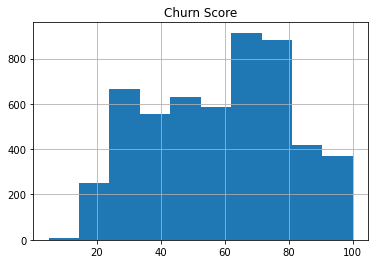

In [152]:
train.hist('Churn Score')

In [161]:
train['Churn Score']
train[target_feature]

best_split = None
best_score = 0

splits = list(range(100))

for split in splits:
    preds = train['Churn Score'] > split
    score = roc_auc_score(train[target_feature], preds)
    
    if score > best_score:
        best_score = score
        best_split = split
    
print(best_score, best_split)

0.8683537832310838 64


In [164]:
X_train, X_val, y_train, y_val = train_test_split(train[train_features], train['Churn Score'],
                                                  test_size=0.2, random_state=42)

## Regression model

In [246]:
model_regr = CatBoostRegressor(cat_features=cat_features)
cv = cross_val_score(model_regr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

Learning rate set to 0.048478
0:	learn: 0.4312973	total: 29ms	remaining: 29s
1:	learn: 0.4256014	total: 62.8ms	remaining: 31.3s
2:	learn: 0.4210811	total: 92.8ms	remaining: 30.8s
3:	learn: 0.4171584	total: 123ms	remaining: 30.6s
4:	learn: 0.4129285	total: 153ms	remaining: 30.5s
5:	learn: 0.4091924	total: 183ms	remaining: 30.2s
6:	learn: 0.4057499	total: 220ms	remaining: 31.2s
7:	learn: 0.4024868	total: 254ms	remaining: 31.5s
8:	learn: 0.3991417	total: 286ms	remaining: 31.5s
9:	learn: 0.3964033	total: 315ms	remaining: 31.2s
10:	learn: 0.3939506	total: 338ms	remaining: 30.4s
11:	learn: 0.3914792	total: 368ms	remaining: 30.3s
12:	learn: 0.3897550	total: 387ms	remaining: 29.4s
13:	learn: 0.3878242	total: 419ms	remaining: 29.5s
14:	learn: 0.3859071	total: 469ms	remaining: 30.8s
15:	learn: 0.3843084	total: 489ms	remaining: 30.1s
16:	learn: 0.3823195	total: 519ms	remaining: 30s
17:	learn: 0.3807195	total: 551ms	remaining: 30s
18:	learn: 0.3790007	total: 583ms	remaining: 30.1s
19:	learn: 0.377

161:	learn: 0.3384902	total: 6.06s	remaining: 31.4s
162:	learn: 0.3384099	total: 6.09s	remaining: 31.3s
163:	learn: 0.3383003	total: 6.12s	remaining: 31.2s
164:	learn: 0.3380847	total: 6.16s	remaining: 31.2s
165:	learn: 0.3380341	total: 6.19s	remaining: 31.1s
166:	learn: 0.3379224	total: 6.22s	remaining: 31s
167:	learn: 0.3378565	total: 6.25s	remaining: 30.9s
168:	learn: 0.3377961	total: 6.28s	remaining: 30.9s
169:	learn: 0.3375305	total: 6.31s	remaining: 30.8s
170:	learn: 0.3374656	total: 6.34s	remaining: 30.8s
171:	learn: 0.3373845	total: 6.38s	remaining: 30.7s
172:	learn: 0.3372311	total: 6.41s	remaining: 30.6s
173:	learn: 0.3371439	total: 6.45s	remaining: 30.6s
174:	learn: 0.3369685	total: 6.48s	remaining: 30.5s
175:	learn: 0.3369227	total: 6.51s	remaining: 30.5s
176:	learn: 0.3368000	total: 6.55s	remaining: 30.5s
177:	learn: 0.3367278	total: 6.58s	remaining: 30.4s
178:	learn: 0.3365775	total: 6.62s	remaining: 30.4s
179:	learn: 0.3365621	total: 6.66s	remaining: 30.3s
180:	learn: 0.

322:	learn: 0.3219996	total: 11.9s	remaining: 25s
323:	learn: 0.3218856	total: 12s	remaining: 25s
324:	learn: 0.3218441	total: 12s	remaining: 24.9s
325:	learn: 0.3217754	total: 12s	remaining: 24.9s
326:	learn: 0.3216371	total: 12.1s	remaining: 24.9s
327:	learn: 0.3215559	total: 12.1s	remaining: 24.8s
328:	learn: 0.3213403	total: 12.2s	remaining: 24.8s
329:	learn: 0.3212813	total: 12.2s	remaining: 24.7s
330:	learn: 0.3212241	total: 12.2s	remaining: 24.7s
331:	learn: 0.3211331	total: 12.2s	remaining: 24.6s
332:	learn: 0.3210594	total: 12.3s	remaining: 24.6s
333:	learn: 0.3209256	total: 12.3s	remaining: 24.5s
334:	learn: 0.3208987	total: 12.4s	remaining: 24.5s
335:	learn: 0.3207440	total: 12.4s	remaining: 24.5s
336:	learn: 0.3206779	total: 12.4s	remaining: 24.4s
337:	learn: 0.3205923	total: 12.5s	remaining: 24.4s
338:	learn: 0.3204825	total: 12.5s	remaining: 24.4s
339:	learn: 0.3203358	total: 12.5s	remaining: 24.3s
340:	learn: 0.3203116	total: 12.6s	remaining: 24.3s
341:	learn: 0.3201761	

482:	learn: 0.3082433	total: 17.6s	remaining: 18.8s
483:	learn: 0.3081174	total: 17.6s	remaining: 18.8s
484:	learn: 0.3080781	total: 17.6s	remaining: 18.7s
485:	learn: 0.3080593	total: 17.7s	remaining: 18.7s
486:	learn: 0.3079903	total: 17.7s	remaining: 18.6s
487:	learn: 0.3078714	total: 17.7s	remaining: 18.6s
488:	learn: 0.3077986	total: 17.8s	remaining: 18.6s
489:	learn: 0.3077224	total: 17.8s	remaining: 18.5s
490:	learn: 0.3076672	total: 17.8s	remaining: 18.5s
491:	learn: 0.3075998	total: 17.9s	remaining: 18.4s
492:	learn: 0.3075601	total: 17.9s	remaining: 18.4s
493:	learn: 0.3074395	total: 17.9s	remaining: 18.4s
494:	learn: 0.3073537	total: 18s	remaining: 18.3s
495:	learn: 0.3072272	total: 18s	remaining: 18.3s
496:	learn: 0.3071993	total: 18s	remaining: 18.2s
497:	learn: 0.3071361	total: 18.1s	remaining: 18.2s
498:	learn: 0.3070383	total: 18.1s	remaining: 18.2s
499:	learn: 0.3069711	total: 18.1s	remaining: 18.1s
500:	learn: 0.3068607	total: 18.2s	remaining: 18.1s
501:	learn: 0.3068

644:	learn: 0.2953731	total: 23.1s	remaining: 12.7s
645:	learn: 0.2952709	total: 23.1s	remaining: 12.7s
646:	learn: 0.2951431	total: 23.2s	remaining: 12.6s
647:	learn: 0.2951025	total: 23.2s	remaining: 12.6s
648:	learn: 0.2950400	total: 23.2s	remaining: 12.6s
649:	learn: 0.2949739	total: 23.3s	remaining: 12.5s
650:	learn: 0.2949429	total: 23.3s	remaining: 12.5s
651:	learn: 0.2947723	total: 23.4s	remaining: 12.5s
652:	learn: 0.2946945	total: 23.4s	remaining: 12.4s
653:	learn: 0.2945398	total: 23.4s	remaining: 12.4s
654:	learn: 0.2944604	total: 23.5s	remaining: 12.4s
655:	learn: 0.2943973	total: 23.5s	remaining: 12.3s
656:	learn: 0.2942984	total: 23.5s	remaining: 12.3s
657:	learn: 0.2942458	total: 23.6s	remaining: 12.2s
658:	learn: 0.2941960	total: 23.6s	remaining: 12.2s
659:	learn: 0.2941760	total: 23.6s	remaining: 12.2s
660:	learn: 0.2940751	total: 23.6s	remaining: 12.1s
661:	learn: 0.2940417	total: 23.7s	remaining: 12.1s
662:	learn: 0.2939789	total: 23.7s	remaining: 12.1s
663:	learn: 

804:	learn: 0.2832545	total: 28.4s	remaining: 6.88s
805:	learn: 0.2831724	total: 28.4s	remaining: 6.84s
806:	learn: 0.2830827	total: 28.5s	remaining: 6.81s
807:	learn: 0.2830668	total: 28.5s	remaining: 6.77s
808:	learn: 0.2830502	total: 28.5s	remaining: 6.74s
809:	learn: 0.2829428	total: 28.6s	remaining: 6.7s
810:	learn: 0.2829120	total: 28.6s	remaining: 6.67s
811:	learn: 0.2827950	total: 28.6s	remaining: 6.63s
812:	learn: 0.2827320	total: 28.7s	remaining: 6.6s
813:	learn: 0.2826837	total: 28.7s	remaining: 6.56s
814:	learn: 0.2826497	total: 28.7s	remaining: 6.53s
815:	learn: 0.2826066	total: 28.8s	remaining: 6.49s
816:	learn: 0.2825892	total: 28.8s	remaining: 6.46s
817:	learn: 0.2825077	total: 28.9s	remaining: 6.42s
818:	learn: 0.2824019	total: 28.9s	remaining: 6.38s
819:	learn: 0.2822747	total: 28.9s	remaining: 6.35s
820:	learn: 0.2822250	total: 29s	remaining: 6.31s
821:	learn: 0.2821477	total: 29s	remaining: 6.28s
822:	learn: 0.2820852	total: 29s	remaining: 6.24s
823:	learn: 0.282047

963:	learn: 0.2734820	total: 34.2s	remaining: 1.28s
964:	learn: 0.2734733	total: 34.2s	remaining: 1.24s
965:	learn: 0.2734131	total: 34.3s	remaining: 1.21s
966:	learn: 0.2733916	total: 34.3s	remaining: 1.17s
967:	learn: 0.2733154	total: 34.4s	remaining: 1.14s
968:	learn: 0.2732664	total: 34.4s	remaining: 1.1s
969:	learn: 0.2732601	total: 34.5s	remaining: 1.07s
970:	learn: 0.2731984	total: 34.5s	remaining: 1.03s
971:	learn: 0.2731623	total: 34.6s	remaining: 996ms
972:	learn: 0.2730261	total: 34.6s	remaining: 960ms
973:	learn: 0.2729504	total: 34.7s	remaining: 925ms
974:	learn: 0.2729462	total: 34.7s	remaining: 890ms
975:	learn: 0.2729227	total: 34.7s	remaining: 854ms
976:	learn: 0.2728499	total: 34.8s	remaining: 819ms
977:	learn: 0.2726895	total: 34.8s	remaining: 783ms
978:	learn: 0.2726541	total: 34.9s	remaining: 748ms
979:	learn: 0.2725960	total: 34.9s	remaining: 713ms
980:	learn: 0.2724422	total: 35s	remaining: 677ms
981:	learn: 0.2724216	total: 35s	remaining: 642ms
982:	learn: 0.272

129:	learn: 0.3427025	total: 3.97s	remaining: 26.6s
130:	learn: 0.3425929	total: 4.01s	remaining: 26.6s
131:	learn: 0.3425672	total: 4.04s	remaining: 26.6s
132:	learn: 0.3422851	total: 4.07s	remaining: 26.5s
133:	learn: 0.3422384	total: 4.1s	remaining: 26.5s
134:	learn: 0.3421875	total: 4.14s	remaining: 26.5s
135:	learn: 0.3420768	total: 4.17s	remaining: 26.5s
136:	learn: 0.3417704	total: 4.2s	remaining: 26.5s
137:	learn: 0.3417151	total: 4.23s	remaining: 26.5s
138:	learn: 0.3417150	total: 4.24s	remaining: 26.3s
139:	learn: 0.3416310	total: 4.27s	remaining: 26.3s
140:	learn: 0.3415768	total: 4.3s	remaining: 26.2s
141:	learn: 0.3415571	total: 4.32s	remaining: 26.1s
142:	learn: 0.3414643	total: 4.35s	remaining: 26.1s
143:	learn: 0.3413534	total: 4.38s	remaining: 26.1s
144:	learn: 0.3413418	total: 4.41s	remaining: 26s
145:	learn: 0.3413208	total: 4.43s	remaining: 25.9s
146:	learn: 0.3413002	total: 4.46s	remaining: 25.9s
147:	learn: 0.3411352	total: 4.49s	remaining: 25.8s
148:	learn: 0.341

292:	learn: 0.3274358	total: 9.12s	remaining: 22s
293:	learn: 0.3274003	total: 9.15s	remaining: 22s
294:	learn: 0.3271138	total: 9.18s	remaining: 21.9s
295:	learn: 0.3269692	total: 9.21s	remaining: 21.9s
296:	learn: 0.3268951	total: 9.24s	remaining: 21.9s
297:	learn: 0.3265927	total: 9.27s	remaining: 21.8s
298:	learn: 0.3265454	total: 9.31s	remaining: 21.8s
299:	learn: 0.3265084	total: 9.34s	remaining: 21.8s
300:	learn: 0.3263488	total: 9.38s	remaining: 21.8s
301:	learn: 0.3262592	total: 9.41s	remaining: 21.7s
302:	learn: 0.3260661	total: 9.44s	remaining: 21.7s
303:	learn: 0.3258942	total: 9.47s	remaining: 21.7s
304:	learn: 0.3257850	total: 9.51s	remaining: 21.7s
305:	learn: 0.3257471	total: 9.54s	remaining: 21.6s
306:	learn: 0.3257430	total: 9.57s	remaining: 21.6s
307:	learn: 0.3256454	total: 9.61s	remaining: 21.6s
308:	learn: 0.3255827	total: 9.63s	remaining: 21.5s
309:	learn: 0.3254512	total: 9.67s	remaining: 21.5s
310:	learn: 0.3253573	total: 9.71s	remaining: 21.5s
311:	learn: 0.32

456:	learn: 0.3119871	total: 16.2s	remaining: 19.2s
457:	learn: 0.3119739	total: 16.2s	remaining: 19.2s
458:	learn: 0.3117750	total: 16.3s	remaining: 19.2s
459:	learn: 0.3117357	total: 16.3s	remaining: 19.1s
460:	learn: 0.3115714	total: 16.3s	remaining: 19.1s
461:	learn: 0.3114910	total: 16.4s	remaining: 19s
462:	learn: 0.3114340	total: 16.4s	remaining: 19s
463:	learn: 0.3112514	total: 16.4s	remaining: 19s
464:	learn: 0.3112343	total: 16.5s	remaining: 18.9s
465:	learn: 0.3111762	total: 16.5s	remaining: 18.9s
466:	learn: 0.3111223	total: 16.5s	remaining: 18.8s
467:	learn: 0.3110689	total: 16.5s	remaining: 18.8s
468:	learn: 0.3110530	total: 16.6s	remaining: 18.8s
469:	learn: 0.3110327	total: 16.6s	remaining: 18.7s
470:	learn: 0.3109685	total: 16.6s	remaining: 18.7s
471:	learn: 0.3108935	total: 16.7s	remaining: 18.6s
472:	learn: 0.3108736	total: 16.7s	remaining: 18.6s
473:	learn: 0.3108156	total: 16.7s	remaining: 18.6s
474:	learn: 0.3107577	total: 16.8s	remaining: 18.5s
475:	learn: 0.3107

618:	learn: 0.2984850	total: 22.7s	remaining: 13.9s
619:	learn: 0.2983629	total: 22.7s	remaining: 13.9s
620:	learn: 0.2982824	total: 22.7s	remaining: 13.9s
621:	learn: 0.2982575	total: 22.9s	remaining: 13.9s
622:	learn: 0.2982161	total: 23s	remaining: 13.9s
623:	learn: 0.2981196	total: 23s	remaining: 13.9s
624:	learn: 0.2981007	total: 23.1s	remaining: 13.9s
625:	learn: 0.2980588	total: 23.1s	remaining: 13.8s
626:	learn: 0.2979533	total: 23.2s	remaining: 13.8s
627:	learn: 0.2978659	total: 23.2s	remaining: 13.8s
628:	learn: 0.2978508	total: 23.3s	remaining: 13.7s
629:	learn: 0.2977694	total: 23.3s	remaining: 13.7s
630:	learn: 0.2977601	total: 23.4s	remaining: 13.7s
631:	learn: 0.2976738	total: 23.4s	remaining: 13.6s
632:	learn: 0.2975730	total: 23.4s	remaining: 13.6s
633:	learn: 0.2974795	total: 23.5s	remaining: 13.6s
634:	learn: 0.2973733	total: 23.5s	remaining: 13.5s
635:	learn: 0.2972073	total: 23.6s	remaining: 13.5s
636:	learn: 0.2971838	total: 23.6s	remaining: 13.5s
637:	learn: 0.29

780:	learn: 0.2861042	total: 29.5s	remaining: 8.26s
781:	learn: 0.2860615	total: 29.5s	remaining: 8.22s
782:	learn: 0.2860388	total: 29.5s	remaining: 8.18s
783:	learn: 0.2859878	total: 29.6s	remaining: 8.14s
784:	learn: 0.2858956	total: 29.6s	remaining: 8.1s
785:	learn: 0.2858634	total: 29.6s	remaining: 8.06s
786:	learn: 0.2858092	total: 29.7s	remaining: 8.03s
787:	learn: 0.2857529	total: 29.7s	remaining: 7.99s
788:	learn: 0.2856769	total: 29.7s	remaining: 7.95s
789:	learn: 0.2855566	total: 29.8s	remaining: 7.91s
790:	learn: 0.2854194	total: 29.8s	remaining: 7.87s
791:	learn: 0.2853695	total: 29.8s	remaining: 7.83s
792:	learn: 0.2853121	total: 29.8s	remaining: 7.79s
793:	learn: 0.2852121	total: 29.9s	remaining: 7.75s
794:	learn: 0.2850312	total: 29.9s	remaining: 7.71s
795:	learn: 0.2849729	total: 29.9s	remaining: 7.67s
796:	learn: 0.2848138	total: 30s	remaining: 7.63s
797:	learn: 0.2846300	total: 30s	remaining: 7.6s
798:	learn: 0.2845541	total: 30s	remaining: 7.56s
799:	learn: 0.284516

941:	learn: 0.2747251	total: 34.8s	remaining: 2.14s
942:	learn: 0.2746220	total: 34.8s	remaining: 2.1s
943:	learn: 0.2745127	total: 34.9s	remaining: 2.07s
944:	learn: 0.2744372	total: 34.9s	remaining: 2.03s
945:	learn: 0.2743734	total: 34.9s	remaining: 1.99s
946:	learn: 0.2742123	total: 35s	remaining: 1.96s
947:	learn: 0.2741046	total: 35s	remaining: 1.92s
948:	learn: 0.2739811	total: 35s	remaining: 1.88s
949:	learn: 0.2739411	total: 35s	remaining: 1.84s
950:	learn: 0.2738797	total: 35.1s	remaining: 1.81s
951:	learn: 0.2738032	total: 35.1s	remaining: 1.77s
952:	learn: 0.2736934	total: 35.1s	remaining: 1.73s
953:	learn: 0.2735292	total: 35.2s	remaining: 1.7s
954:	learn: 0.2734177	total: 35.2s	remaining: 1.66s
955:	learn: 0.2733883	total: 35.3s	remaining: 1.62s
956:	learn: 0.2732153	total: 35.3s	remaining: 1.58s
957:	learn: 0.2731409	total: 35.3s	remaining: 1.55s
958:	learn: 0.2730637	total: 35.3s	remaining: 1.51s
959:	learn: 0.2730182	total: 35.4s	remaining: 1.47s
960:	learn: 0.2728104	

101:	learn: 0.3453465	total: 3.36s	remaining: 29.6s
102:	learn: 0.3450003	total: 3.4s	remaining: 29.6s
103:	learn: 0.3450001	total: 3.4s	remaining: 29.3s
104:	learn: 0.3447960	total: 3.44s	remaining: 29.3s
105:	learn: 0.3447851	total: 3.46s	remaining: 29.2s
106:	learn: 0.3445893	total: 3.49s	remaining: 29.1s
107:	learn: 0.3444548	total: 3.52s	remaining: 29.1s
108:	learn: 0.3443549	total: 3.55s	remaining: 29s
109:	learn: 0.3442221	total: 3.59s	remaining: 29s
110:	learn: 0.3441613	total: 3.62s	remaining: 29s
111:	learn: 0.3440295	total: 3.65s	remaining: 28.9s
112:	learn: 0.3439419	total: 3.68s	remaining: 28.9s
113:	learn: 0.3438619	total: 3.71s	remaining: 28.9s
114:	learn: 0.3436287	total: 3.75s	remaining: 28.9s
115:	learn: 0.3435090	total: 3.79s	remaining: 28.8s
116:	learn: 0.3435022	total: 3.79s	remaining: 28.6s
117:	learn: 0.3433660	total: 3.82s	remaining: 28.6s
118:	learn: 0.3430933	total: 3.85s	remaining: 28.5s
119:	learn: 0.3430080	total: 3.89s	remaining: 28.5s
120:	learn: 0.342982

261:	learn: 0.3259492	total: 8.74s	remaining: 24.6s
262:	learn: 0.3258233	total: 8.77s	remaining: 24.6s
263:	learn: 0.3257248	total: 8.85s	remaining: 24.7s
264:	learn: 0.3254908	total: 8.94s	remaining: 24.8s
265:	learn: 0.3253333	total: 8.98s	remaining: 24.8s
266:	learn: 0.3252006	total: 9.01s	remaining: 24.7s
267:	learn: 0.3251548	total: 9.05s	remaining: 24.7s
268:	learn: 0.3250349	total: 9.08s	remaining: 24.7s
269:	learn: 0.3248733	total: 9.12s	remaining: 24.7s
270:	learn: 0.3247580	total: 9.16s	remaining: 24.6s
271:	learn: 0.3247299	total: 9.19s	remaining: 24.6s
272:	learn: 0.3245944	total: 9.22s	remaining: 24.6s
273:	learn: 0.3244887	total: 9.26s	remaining: 24.5s
274:	learn: 0.3243457	total: 9.29s	remaining: 24.5s
275:	learn: 0.3243154	total: 9.33s	remaining: 24.5s
276:	learn: 0.3242161	total: 9.38s	remaining: 24.5s
277:	learn: 0.3241887	total: 9.42s	remaining: 24.5s
278:	learn: 0.3241189	total: 9.46s	remaining: 24.4s
279:	learn: 0.3240827	total: 9.5s	remaining: 24.4s
280:	learn: 0

420:	learn: 0.3113983	total: 14.9s	remaining: 20.5s
421:	learn: 0.3113010	total: 14.9s	remaining: 20.5s
422:	learn: 0.3112226	total: 15s	remaining: 20.4s
423:	learn: 0.3110779	total: 15s	remaining: 20.4s
424:	learn: 0.3110241	total: 15s	remaining: 20.3s
425:	learn: 0.3109172	total: 15.1s	remaining: 20.3s
426:	learn: 0.3107901	total: 15.1s	remaining: 20.3s
427:	learn: 0.3106518	total: 15.1s	remaining: 20.2s
428:	learn: 0.3104935	total: 15.2s	remaining: 20.2s
429:	learn: 0.3104176	total: 15.2s	remaining: 20.2s
430:	learn: 0.3102815	total: 15.2s	remaining: 20.1s
431:	learn: 0.3102023	total: 15.3s	remaining: 20.1s
432:	learn: 0.3101115	total: 15.3s	remaining: 20s
433:	learn: 0.3099741	total: 15.3s	remaining: 20s
434:	learn: 0.3098772	total: 15.4s	remaining: 20s
435:	learn: 0.3098004	total: 15.4s	remaining: 19.9s
436:	learn: 0.3097172	total: 15.5s	remaining: 19.9s
437:	learn: 0.3096696	total: 15.5s	remaining: 19.9s
438:	learn: 0.3094931	total: 15.5s	remaining: 19.8s
439:	learn: 0.3094640	to

585:	learn: 0.2978638	total: 21s	remaining: 14.8s
586:	learn: 0.2978094	total: 21s	remaining: 14.8s
587:	learn: 0.2978068	total: 21.1s	remaining: 14.8s
588:	learn: 0.2975955	total: 21.1s	remaining: 14.7s
589:	learn: 0.2975529	total: 21.1s	remaining: 14.7s
590:	learn: 0.2974559	total: 21.2s	remaining: 14.6s
591:	learn: 0.2974141	total: 21.2s	remaining: 14.6s
592:	learn: 0.2973698	total: 21.2s	remaining: 14.6s
593:	learn: 0.2972227	total: 21.3s	remaining: 14.5s
594:	learn: 0.2971812	total: 21.3s	remaining: 14.5s
595:	learn: 0.2971333	total: 21.3s	remaining: 14.5s
596:	learn: 0.2970746	total: 21.4s	remaining: 14.4s
597:	learn: 0.2968893	total: 21.4s	remaining: 14.4s
598:	learn: 0.2968076	total: 21.4s	remaining: 14.3s
599:	learn: 0.2967422	total: 21.5s	remaining: 14.3s
600:	learn: 0.2966284	total: 21.5s	remaining: 14.3s
601:	learn: 0.2965726	total: 21.5s	remaining: 14.2s
602:	learn: 0.2963438	total: 21.6s	remaining: 14.2s
603:	learn: 0.2962776	total: 21.6s	remaining: 14.2s
604:	learn: 0.29

748:	learn: 0.2859404	total: 26.6s	remaining: 8.91s
749:	learn: 0.2857873	total: 26.6s	remaining: 8.88s
750:	learn: 0.2857490	total: 26.7s	remaining: 8.84s
751:	learn: 0.2857017	total: 26.7s	remaining: 8.8s
752:	learn: 0.2856663	total: 26.7s	remaining: 8.77s
753:	learn: 0.2854697	total: 26.8s	remaining: 8.73s
754:	learn: 0.2854117	total: 26.8s	remaining: 8.69s
755:	learn: 0.2853600	total: 26.8s	remaining: 8.66s
756:	learn: 0.2853238	total: 26.9s	remaining: 8.62s
757:	learn: 0.2851644	total: 26.9s	remaining: 8.59s
758:	learn: 0.2851373	total: 26.9s	remaining: 8.55s
759:	learn: 0.2851028	total: 27s	remaining: 8.51s
760:	learn: 0.2849210	total: 27s	remaining: 8.48s
761:	learn: 0.2848218	total: 27s	remaining: 8.45s
762:	learn: 0.2847887	total: 27.1s	remaining: 8.41s
763:	learn: 0.2846443	total: 27.1s	remaining: 8.38s
764:	learn: 0.2844154	total: 27.2s	remaining: 8.34s
765:	learn: 0.2843525	total: 27.2s	remaining: 8.31s
766:	learn: 0.2843055	total: 27.2s	remaining: 8.27s
767:	learn: 0.28429

907:	learn: 0.2733341	total: 34.3s	remaining: 3.48s
908:	learn: 0.2732639	total: 34.4s	remaining: 3.44s
909:	learn: 0.2731741	total: 34.4s	remaining: 3.4s
910:	learn: 0.2731031	total: 34.4s	remaining: 3.36s
911:	learn: 0.2730546	total: 34.5s	remaining: 3.33s
912:	learn: 0.2729606	total: 34.5s	remaining: 3.29s
913:	learn: 0.2728000	total: 34.6s	remaining: 3.25s
914:	learn: 0.2727512	total: 34.6s	remaining: 3.22s
915:	learn: 0.2726622	total: 34.7s	remaining: 3.18s
916:	learn: 0.2725565	total: 34.7s	remaining: 3.14s
917:	learn: 0.2724191	total: 34.8s	remaining: 3.11s
918:	learn: 0.2723493	total: 34.8s	remaining: 3.07s
919:	learn: 0.2723298	total: 34.9s	remaining: 3.03s
920:	learn: 0.2722872	total: 34.9s	remaining: 2.99s
921:	learn: 0.2722081	total: 35s	remaining: 2.96s
922:	learn: 0.2721335	total: 35s	remaining: 2.92s
923:	learn: 0.2720567	total: 35.1s	remaining: 2.88s
924:	learn: 0.2719886	total: 35.1s	remaining: 2.85s
925:	learn: 0.2719209	total: 35.1s	remaining: 2.81s
926:	learn: 0.271

68:	learn: 0.3526081	total: 4.66s	remaining: 1m 2s
69:	learn: 0.3523482	total: 4.75s	remaining: 1m 3s
70:	learn: 0.3520428	total: 4.84s	remaining: 1m 3s
71:	learn: 0.3517498	total: 4.92s	remaining: 1m 3s
72:	learn: 0.3515868	total: 4.96s	remaining: 1m 3s
73:	learn: 0.3513836	total: 5.01s	remaining: 1m 2s
74:	learn: 0.3511466	total: 5.05s	remaining: 1m 2s
75:	learn: 0.3508403	total: 5.1s	remaining: 1m 2s
76:	learn: 0.3505786	total: 5.14s	remaining: 1m 1s
77:	learn: 0.3504906	total: 5.18s	remaining: 1m 1s
78:	learn: 0.3503599	total: 5.23s	remaining: 1m 1s
79:	learn: 0.3501575	total: 5.28s	remaining: 1m
80:	learn: 0.3498120	total: 5.32s	remaining: 1m
81:	learn: 0.3496969	total: 5.36s	remaining: 1m
82:	learn: 0.3495769	total: 5.41s	remaining: 59.7s
83:	learn: 0.3493901	total: 5.45s	remaining: 59.5s
84:	learn: 0.3493758	total: 5.5s	remaining: 59.2s
85:	learn: 0.3491517	total: 5.54s	remaining: 58.9s
86:	learn: 0.3490441	total: 5.59s	remaining: 58.6s
87:	learn: 0.3489149	total: 5.63s	remainin

230:	learn: 0.3330529	total: 12.8s	remaining: 42.7s
231:	learn: 0.3328966	total: 12.9s	remaining: 42.6s
232:	learn: 0.3327740	total: 12.9s	remaining: 42.5s
233:	learn: 0.3326218	total: 13s	remaining: 42.4s
234:	learn: 0.3324771	total: 13s	remaining: 42.3s
235:	learn: 0.3323855	total: 13s	remaining: 42.2s
236:	learn: 0.3323648	total: 13.1s	remaining: 42.1s
237:	learn: 0.3322219	total: 13.1s	remaining: 42s
238:	learn: 0.3320216	total: 13.1s	remaining: 41.9s
239:	learn: 0.3318522	total: 13.2s	remaining: 41.8s
240:	learn: 0.3318378	total: 13.2s	remaining: 41.7s
241:	learn: 0.3317141	total: 13.3s	remaining: 41.6s
242:	learn: 0.3316798	total: 13.3s	remaining: 41.5s
243:	learn: 0.3315776	total: 13.4s	remaining: 41.4s
244:	learn: 0.3315619	total: 13.4s	remaining: 41.3s
245:	learn: 0.3314972	total: 13.4s	remaining: 41.2s
246:	learn: 0.3314823	total: 13.6s	remaining: 41.6s
247:	learn: 0.3314647	total: 13.7s	remaining: 41.6s
248:	learn: 0.3313992	total: 13.8s	remaining: 41.7s
249:	learn: 0.331273

391:	learn: 0.3183565	total: 19.6s	remaining: 30.4s
392:	learn: 0.3182637	total: 19.6s	remaining: 30.3s
393:	learn: 0.3181958	total: 19.7s	remaining: 30.2s
394:	learn: 0.3179776	total: 19.7s	remaining: 30.2s
395:	learn: 0.3179217	total: 19.7s	remaining: 30.1s
396:	learn: 0.3178548	total: 19.7s	remaining: 30s
397:	learn: 0.3177143	total: 19.8s	remaining: 29.9s
398:	learn: 0.3176880	total: 19.8s	remaining: 29.9s
399:	learn: 0.3175521	total: 19.9s	remaining: 29.8s
400:	learn: 0.3174576	total: 19.9s	remaining: 29.7s
401:	learn: 0.3172432	total: 19.9s	remaining: 29.6s
402:	learn: 0.3171807	total: 20s	remaining: 29.6s
403:	learn: 0.3171069	total: 20s	remaining: 29.5s
404:	learn: 0.3170589	total: 20s	remaining: 29.4s
405:	learn: 0.3169307	total: 20.1s	remaining: 29.4s
406:	learn: 0.3169207	total: 20.1s	remaining: 29.3s
407:	learn: 0.3167891	total: 20.1s	remaining: 29.2s
408:	learn: 0.3167409	total: 20.2s	remaining: 29.1s
409:	learn: 0.3166721	total: 20.2s	remaining: 29.1s
410:	learn: 0.316508

552:	learn: 0.3026876	total: 25.8s	remaining: 20.9s
553:	learn: 0.3026426	total: 25.9s	remaining: 20.8s
554:	learn: 0.3025707	total: 25.9s	remaining: 20.8s
555:	learn: 0.3023415	total: 26s	remaining: 20.7s
556:	learn: 0.3022676	total: 26s	remaining: 20.7s
557:	learn: 0.3022428	total: 26s	remaining: 20.6s
558:	learn: 0.3021604	total: 26.1s	remaining: 20.6s
559:	learn: 0.3021173	total: 26.1s	remaining: 20.5s
560:	learn: 0.3020390	total: 26.1s	remaining: 20.4s
561:	learn: 0.3019643	total: 26.2s	remaining: 20.4s
562:	learn: 0.3018993	total: 26.2s	remaining: 20.3s
563:	learn: 0.3018644	total: 26.3s	remaining: 20.3s
564:	learn: 0.3017943	total: 26.3s	remaining: 20.2s
565:	learn: 0.3017162	total: 26.3s	remaining: 20.2s
566:	learn: 0.3016364	total: 26.4s	remaining: 20.1s
567:	learn: 0.3015514	total: 26.4s	remaining: 20.1s
568:	learn: 0.3014913	total: 26.5s	remaining: 20s
569:	learn: 0.3014327	total: 26.5s	remaining: 20s
570:	learn: 0.3013505	total: 26.5s	remaining: 19.9s
571:	learn: 0.3012763	

712:	learn: 0.2895316	total: 32.2s	remaining: 13s
713:	learn: 0.2893818	total: 32.3s	remaining: 12.9s
714:	learn: 0.2893449	total: 32.3s	remaining: 12.9s
715:	learn: 0.2892429	total: 32.4s	remaining: 12.8s
716:	learn: 0.2891159	total: 32.4s	remaining: 12.8s
717:	learn: 0.2890053	total: 32.4s	remaining: 12.7s
718:	learn: 0.2889128	total: 32.5s	remaining: 12.7s
719:	learn: 0.2888975	total: 32.5s	remaining: 12.6s
720:	learn: 0.2888915	total: 32.6s	remaining: 12.6s
721:	learn: 0.2887780	total: 32.6s	remaining: 12.6s
722:	learn: 0.2886702	total: 32.7s	remaining: 12.5s
723:	learn: 0.2885753	total: 32.7s	remaining: 12.5s
724:	learn: 0.2885433	total: 32.7s	remaining: 12.4s
725:	learn: 0.2883392	total: 32.8s	remaining: 12.4s
726:	learn: 0.2881605	total: 32.8s	remaining: 12.3s
727:	learn: 0.2881205	total: 32.9s	remaining: 12.3s
728:	learn: 0.2880793	total: 32.9s	remaining: 12.2s
729:	learn: 0.2879688	total: 32.9s	remaining: 12.2s
730:	learn: 0.2879082	total: 33s	remaining: 12.1s
731:	learn: 0.28

873:	learn: 0.2753523	total: 39.2s	remaining: 5.65s
874:	learn: 0.2753117	total: 39.3s	remaining: 5.61s
875:	learn: 0.2751833	total: 39.3s	remaining: 5.56s
876:	learn: 0.2750263	total: 39.4s	remaining: 5.52s
877:	learn: 0.2749748	total: 39.4s	remaining: 5.47s
878:	learn: 0.2747931	total: 39.5s	remaining: 5.43s
879:	learn: 0.2746702	total: 39.5s	remaining: 5.38s
880:	learn: 0.2746196	total: 39.5s	remaining: 5.34s
881:	learn: 0.2745340	total: 39.6s	remaining: 5.29s
882:	learn: 0.2745069	total: 39.6s	remaining: 5.25s
883:	learn: 0.2743990	total: 39.7s	remaining: 5.2s
884:	learn: 0.2743488	total: 39.7s	remaining: 5.16s
885:	learn: 0.2743263	total: 39.8s	remaining: 5.12s
886:	learn: 0.2741478	total: 39.8s	remaining: 5.07s
887:	learn: 0.2741169	total: 39.8s	remaining: 5.03s
888:	learn: 0.2740650	total: 39.9s	remaining: 4.98s
889:	learn: 0.2739949	total: 39.9s	remaining: 4.93s
890:	learn: 0.2739754	total: 40s	remaining: 4.89s
891:	learn: 0.2739588	total: 40s	remaining: 4.85s
892:	learn: 0.273

32:	learn: 0.3663162	total: 1.06s	remaining: 31s
33:	learn: 0.3656392	total: 1.09s	remaining: 31s
34:	learn: 0.3650063	total: 1.12s	remaining: 31s
35:	learn: 0.3641182	total: 1.16s	remaining: 30.9s
36:	learn: 0.3635517	total: 1.19s	remaining: 30.9s
37:	learn: 0.3630208	total: 1.23s	remaining: 31.1s
38:	learn: 0.3624810	total: 1.27s	remaining: 31.3s
39:	learn: 0.3620530	total: 1.3s	remaining: 31.2s
40:	learn: 0.3615866	total: 1.33s	remaining: 31.1s
41:	learn: 0.3615118	total: 1.34s	remaining: 30.6s
42:	learn: 0.3610757	total: 1.37s	remaining: 30.5s
43:	learn: 0.3606179	total: 1.4s	remaining: 30.4s
44:	learn: 0.3599828	total: 1.43s	remaining: 30.4s
45:	learn: 0.3598789	total: 1.45s	remaining: 30.1s
46:	learn: 0.3594006	total: 1.49s	remaining: 30.2s
47:	learn: 0.3588288	total: 1.52s	remaining: 30.2s
48:	learn: 0.3585036	total: 1.55s	remaining: 30.1s
49:	learn: 0.3581856	total: 1.58s	remaining: 30s
50:	learn: 0.3576598	total: 1.61s	remaining: 30s
51:	learn: 0.3572572	total: 1.65s	remaining

194:	learn: 0.3389689	total: 6.11s	remaining: 25.2s
195:	learn: 0.3387969	total: 6.14s	remaining: 25.2s
196:	learn: 0.3387264	total: 6.17s	remaining: 25.2s
197:	learn: 0.3386283	total: 6.2s	remaining: 25.1s
198:	learn: 0.3384423	total: 6.24s	remaining: 25.1s
199:	learn: 0.3384177	total: 6.26s	remaining: 25.1s
200:	learn: 0.3383454	total: 6.3s	remaining: 25.1s
201:	learn: 0.3382354	total: 6.33s	remaining: 25s
202:	learn: 0.3381368	total: 6.36s	remaining: 25s
203:	learn: 0.3380959	total: 6.39s	remaining: 25s
204:	learn: 0.3379919	total: 6.43s	remaining: 24.9s
205:	learn: 0.3379892	total: 6.46s	remaining: 24.9s
206:	learn: 0.3379866	total: 6.49s	remaining: 24.9s
207:	learn: 0.3378203	total: 6.52s	remaining: 24.8s
208:	learn: 0.3377614	total: 6.55s	remaining: 24.8s
209:	learn: 0.3375955	total: 6.58s	remaining: 24.8s
210:	learn: 0.3374942	total: 6.61s	remaining: 24.7s
211:	learn: 0.3373783	total: 6.65s	remaining: 24.7s
212:	learn: 0.3372898	total: 6.69s	remaining: 24.7s
213:	learn: 0.337081

358:	learn: 0.3231081	total: 12.2s	remaining: 21.8s
359:	learn: 0.3230080	total: 12.3s	remaining: 21.8s
360:	learn: 0.3228068	total: 12.3s	remaining: 21.8s
361:	learn: 0.3227806	total: 12.3s	remaining: 21.7s
362:	learn: 0.3227529	total: 12.4s	remaining: 21.7s
363:	learn: 0.3226780	total: 12.4s	remaining: 21.7s
364:	learn: 0.3225180	total: 12.5s	remaining: 21.8s
365:	learn: 0.3224285	total: 12.6s	remaining: 21.8s
366:	learn: 0.3223051	total: 12.6s	remaining: 21.7s
367:	learn: 0.3222729	total: 12.7s	remaining: 21.7s
368:	learn: 0.3222304	total: 12.7s	remaining: 21.7s
369:	learn: 0.3220411	total: 12.7s	remaining: 21.7s
370:	learn: 0.3219569	total: 12.8s	remaining: 21.7s
371:	learn: 0.3218594	total: 12.8s	remaining: 21.6s
372:	learn: 0.3217962	total: 12.8s	remaining: 21.6s
373:	learn: 0.3217395	total: 12.9s	remaining: 21.6s
374:	learn: 0.3217139	total: 12.9s	remaining: 21.5s
375:	learn: 0.3216601	total: 12.9s	remaining: 21.5s
376:	learn: 0.3216028	total: 13s	remaining: 21.4s
377:	learn: 0.

519:	learn: 0.3083892	total: 20.4s	remaining: 18.8s
520:	learn: 0.3083350	total: 20.4s	remaining: 18.8s
521:	learn: 0.3082531	total: 20.5s	remaining: 18.7s
522:	learn: 0.3081500	total: 20.5s	remaining: 18.7s
523:	learn: 0.3080432	total: 20.5s	remaining: 18.6s
524:	learn: 0.3079842	total: 20.6s	remaining: 18.6s
525:	learn: 0.3079033	total: 20.6s	remaining: 18.6s
526:	learn: 0.3078612	total: 20.6s	remaining: 18.5s
527:	learn: 0.3075804	total: 20.7s	remaining: 18.5s
528:	learn: 0.3074564	total: 20.7s	remaining: 18.5s
529:	learn: 0.3073965	total: 20.8s	remaining: 18.4s
530:	learn: 0.3073498	total: 20.8s	remaining: 18.4s
531:	learn: 0.3072428	total: 20.9s	remaining: 18.4s
532:	learn: 0.3071986	total: 20.9s	remaining: 18.3s
533:	learn: 0.3071394	total: 21s	remaining: 18.3s
534:	learn: 0.3071106	total: 21s	remaining: 18.3s
535:	learn: 0.3070842	total: 21.1s	remaining: 18.2s
536:	learn: 0.3070032	total: 21.1s	remaining: 18.2s
537:	learn: 0.3069562	total: 21.1s	remaining: 18.1s
538:	learn: 0.30

681:	learn: 0.2948889	total: 26.1s	remaining: 12.1s
682:	learn: 0.2948540	total: 26.1s	remaining: 12.1s
683:	learn: 0.2947817	total: 26.1s	remaining: 12.1s
684:	learn: 0.2946707	total: 26.2s	remaining: 12s
685:	learn: 0.2946566	total: 26.2s	remaining: 12s
686:	learn: 0.2945601	total: 26.2s	remaining: 11.9s
687:	learn: 0.2944989	total: 26.3s	remaining: 11.9s
688:	learn: 0.2943439	total: 26.3s	remaining: 11.9s
689:	learn: 0.2942810	total: 26.3s	remaining: 11.8s
690:	learn: 0.2942297	total: 26.4s	remaining: 11.8s
691:	learn: 0.2940063	total: 26.4s	remaining: 11.7s
692:	learn: 0.2938982	total: 26.4s	remaining: 11.7s
693:	learn: 0.2937792	total: 26.4s	remaining: 11.7s
694:	learn: 0.2937687	total: 26.5s	remaining: 11.6s
695:	learn: 0.2936979	total: 26.5s	remaining: 11.6s
696:	learn: 0.2936224	total: 26.6s	remaining: 11.5s
697:	learn: 0.2935892	total: 26.6s	remaining: 11.5s
698:	learn: 0.2935067	total: 26.6s	remaining: 11.5s
699:	learn: 0.2934093	total: 26.7s	remaining: 11.4s
700:	learn: 0.29

845:	learn: 0.2810988	total: 31.4s	remaining: 5.71s
846:	learn: 0.2809596	total: 31.4s	remaining: 5.67s
847:	learn: 0.2809248	total: 31.4s	remaining: 5.63s
848:	learn: 0.2807836	total: 31.5s	remaining: 5.59s
849:	learn: 0.2807185	total: 31.5s	remaining: 5.56s
850:	learn: 0.2806900	total: 31.5s	remaining: 5.52s
851:	learn: 0.2806560	total: 31.6s	remaining: 5.48s
852:	learn: 0.2805799	total: 31.6s	remaining: 5.44s
853:	learn: 0.2805119	total: 31.6s	remaining: 5.41s
854:	learn: 0.2804360	total: 31.6s	remaining: 5.37s
855:	learn: 0.2804194	total: 31.7s	remaining: 5.33s
856:	learn: 0.2804029	total: 31.7s	remaining: 5.29s
857:	learn: 0.2803430	total: 31.7s	remaining: 5.25s
858:	learn: 0.2803133	total: 31.8s	remaining: 5.21s
859:	learn: 0.2802809	total: 31.8s	remaining: 5.18s
860:	learn: 0.2802304	total: 31.8s	remaining: 5.14s
861:	learn: 0.2801660	total: 31.9s	remaining: 5.1s
862:	learn: 0.2801168	total: 31.9s	remaining: 5.06s
863:	learn: 0.2799529	total: 31.9s	remaining: 5.03s
864:	learn: 0

In [249]:
-cv.mean()

0.13418301630369306

In [252]:
model_regr.fit(X_train, y_train)

Learning rate set to 0.050443
0:	learn: 0.4338022	total: 12.8ms	remaining: 12.8s
1:	learn: 0.4283090	total: 48ms	remaining: 24s
2:	learn: 0.4233229	total: 82.4ms	remaining: 27.4s
3:	learn: 0.4185345	total: 118ms	remaining: 29.3s
4:	learn: 0.4143259	total: 150ms	remaining: 29.8s
5:	learn: 0.4098761	total: 180ms	remaining: 29.9s
6:	learn: 0.4065025	total: 205ms	remaining: 29.1s
7:	learn: 0.4030868	total: 239ms	remaining: 29.6s
8:	learn: 0.4001912	total: 277ms	remaining: 30.5s
9:	learn: 0.3975239	total: 306ms	remaining: 30.3s
10:	learn: 0.3944515	total: 338ms	remaining: 30.4s
11:	learn: 0.3922259	total: 403ms	remaining: 33.2s
12:	learn: 0.3904478	total: 446ms	remaining: 33.9s
13:	learn: 0.3886367	total: 465ms	remaining: 32.8s
14:	learn: 0.3867992	total: 483ms	remaining: 31.7s
15:	learn: 0.3849647	total: 513ms	remaining: 31.6s
16:	learn: 0.3837727	total: 532ms	remaining: 30.8s
17:	learn: 0.3822021	total: 564ms	remaining: 30.8s
18:	learn: 0.3803198	total: 596ms	remaining: 30.8s
19:	learn: 0

162:	learn: 0.3423822	total: 5.91s	remaining: 30.4s
163:	learn: 0.3422479	total: 5.95s	remaining: 30.3s
164:	learn: 0.3421122	total: 5.98s	remaining: 30.3s
165:	learn: 0.3420809	total: 6.01s	remaining: 30.2s
166:	learn: 0.3420045	total: 6.04s	remaining: 30.2s
167:	learn: 0.3417834	total: 6.08s	remaining: 30.1s
168:	learn: 0.3417554	total: 6.11s	remaining: 30s
169:	learn: 0.3416144	total: 6.14s	remaining: 30s
170:	learn: 0.3414876	total: 6.18s	remaining: 30s
171:	learn: 0.3414089	total: 6.22s	remaining: 30s
172:	learn: 0.3410501	total: 6.26s	remaining: 29.9s
173:	learn: 0.3408870	total: 6.3s	remaining: 29.9s
174:	learn: 0.3406816	total: 6.34s	remaining: 29.9s
175:	learn: 0.3405500	total: 6.38s	remaining: 29.9s
176:	learn: 0.3405457	total: 6.42s	remaining: 29.8s
177:	learn: 0.3404040	total: 6.45s	remaining: 29.8s
178:	learn: 0.3403871	total: 6.5s	remaining: 29.8s
179:	learn: 0.3402999	total: 6.54s	remaining: 29.8s
180:	learn: 0.3401698	total: 6.58s	remaining: 29.8s
181:	learn: 0.3399800	

324:	learn: 0.3280021	total: 12.7s	remaining: 26.3s
325:	learn: 0.3279419	total: 12.7s	remaining: 26.3s
326:	learn: 0.3278839	total: 12.7s	remaining: 26.2s
327:	learn: 0.3277147	total: 12.8s	remaining: 26.2s
328:	learn: 0.3276273	total: 12.8s	remaining: 26.1s
329:	learn: 0.3274090	total: 12.9s	remaining: 26.1s
330:	learn: 0.3273500	total: 12.9s	remaining: 26.1s
331:	learn: 0.3272068	total: 12.9s	remaining: 26s
332:	learn: 0.3271248	total: 13s	remaining: 26s
333:	learn: 0.3268975	total: 13s	remaining: 25.9s
334:	learn: 0.3268762	total: 13s	remaining: 25.9s
335:	learn: 0.3267889	total: 13.1s	remaining: 25.8s
336:	learn: 0.3267460	total: 13.1s	remaining: 25.8s
337:	learn: 0.3266953	total: 13.1s	remaining: 25.7s
338:	learn: 0.3266166	total: 13.2s	remaining: 25.7s
339:	learn: 0.3264759	total: 13.2s	remaining: 25.6s
340:	learn: 0.3264584	total: 13.2s	remaining: 25.6s
341:	learn: 0.3264152	total: 13.3s	remaining: 25.5s
342:	learn: 0.3262974	total: 13.3s	remaining: 25.5s
343:	learn: 0.3260705	

483:	learn: 0.3149144	total: 18.9s	remaining: 20.1s
484:	learn: 0.3148123	total: 18.9s	remaining: 20.1s
485:	learn: 0.3147241	total: 18.9s	remaining: 20s
486:	learn: 0.3146678	total: 19s	remaining: 20s
487:	learn: 0.3145796	total: 19s	remaining: 20s
488:	learn: 0.3145038	total: 19.1s	remaining: 19.9s
489:	learn: 0.3144434	total: 19.1s	remaining: 19.9s
490:	learn: 0.3144122	total: 19.2s	remaining: 19.9s
491:	learn: 0.3143906	total: 19.2s	remaining: 19.9s
492:	learn: 0.3142872	total: 19.3s	remaining: 19.8s
493:	learn: 0.3142487	total: 19.3s	remaining: 19.8s
494:	learn: 0.3141780	total: 19.4s	remaining: 19.7s
495:	learn: 0.3140701	total: 19.4s	remaining: 19.7s
496:	learn: 0.3139898	total: 19.4s	remaining: 19.7s
497:	learn: 0.3138713	total: 19.5s	remaining: 19.6s
498:	learn: 0.3138386	total: 19.5s	remaining: 19.6s
499:	learn: 0.3137716	total: 19.5s	remaining: 19.5s
500:	learn: 0.3137113	total: 19.6s	remaining: 19.5s
501:	learn: 0.3136647	total: 19.6s	remaining: 19.4s
502:	learn: 0.3135974	

646:	learn: 0.3033751	total: 24.5s	remaining: 13.4s
647:	learn: 0.3033479	total: 24.5s	remaining: 13.3s
648:	learn: 0.3033278	total: 24.6s	remaining: 13.3s
649:	learn: 0.3032128	total: 24.6s	remaining: 13.2s
650:	learn: 0.3032048	total: 24.6s	remaining: 13.2s
651:	learn: 0.3031163	total: 24.7s	remaining: 13.2s
652:	learn: 0.3030737	total: 24.7s	remaining: 13.1s
653:	learn: 0.3029751	total: 24.7s	remaining: 13.1s
654:	learn: 0.3029170	total: 24.8s	remaining: 13s
655:	learn: 0.3027549	total: 24.8s	remaining: 13s
656:	learn: 0.3026795	total: 24.8s	remaining: 13s
657:	learn: 0.3025833	total: 24.9s	remaining: 12.9s
658:	learn: 0.3025071	total: 24.9s	remaining: 12.9s
659:	learn: 0.3024740	total: 24.9s	remaining: 12.8s
660:	learn: 0.3023802	total: 25s	remaining: 12.8s
661:	learn: 0.3022772	total: 25s	remaining: 12.8s
662:	learn: 0.3022510	total: 25.1s	remaining: 12.7s
663:	learn: 0.3022315	total: 25.1s	remaining: 12.7s
664:	learn: 0.3021507	total: 25.1s	remaining: 12.7s
665:	learn: 0.3021080	

810:	learn: 0.2929452	total: 30.1s	remaining: 7.01s
811:	learn: 0.2929164	total: 30.1s	remaining: 6.97s
812:	learn: 0.2928682	total: 30.1s	remaining: 6.93s
813:	learn: 0.2927816	total: 30.2s	remaining: 6.9s
814:	learn: 0.2927699	total: 30.2s	remaining: 6.86s
815:	learn: 0.2926918	total: 30.2s	remaining: 6.82s
816:	learn: 0.2926611	total: 30.3s	remaining: 6.78s
817:	learn: 0.2926114	total: 30.3s	remaining: 6.74s
818:	learn: 0.2926022	total: 30.3s	remaining: 6.71s
819:	learn: 0.2925021	total: 30.4s	remaining: 6.67s
820:	learn: 0.2924633	total: 30.4s	remaining: 6.63s
821:	learn: 0.2923719	total: 30.4s	remaining: 6.59s
822:	learn: 0.2922301	total: 30.5s	remaining: 6.55s
823:	learn: 0.2922218	total: 30.5s	remaining: 6.51s
824:	learn: 0.2921847	total: 30.5s	remaining: 6.48s
825:	learn: 0.2921497	total: 30.6s	remaining: 6.44s
826:	learn: 0.2921003	total: 30.6s	remaining: 6.4s
827:	learn: 0.2920604	total: 30.6s	remaining: 6.36s
828:	learn: 0.2919626	total: 30.7s	remaining: 6.33s
829:	learn: 0.

971:	learn: 0.2836894	total: 36.5s	remaining: 1.05s
972:	learn: 0.2836242	total: 36.6s	remaining: 1.01s
973:	learn: 0.2835455	total: 36.6s	remaining: 977ms
974:	learn: 0.2834880	total: 36.6s	remaining: 939ms
975:	learn: 0.2833587	total: 36.7s	remaining: 902ms
976:	learn: 0.2832545	total: 36.7s	remaining: 864ms
977:	learn: 0.2831651	total: 36.8s	remaining: 828ms
978:	learn: 0.2831151	total: 36.9s	remaining: 792ms
979:	learn: 0.2830433	total: 37.1s	remaining: 757ms
980:	learn: 0.2829295	total: 37.2s	remaining: 721ms
981:	learn: 0.2828753	total: 37.3s	remaining: 683ms
982:	learn: 0.2828187	total: 37.3s	remaining: 645ms
983:	learn: 0.2827390	total: 37.3s	remaining: 607ms
984:	learn: 0.2826879	total: 37.4s	remaining: 569ms
985:	learn: 0.2826032	total: 37.4s	remaining: 531ms
986:	learn: 0.2825378	total: 37.5s	remaining: 493ms
987:	learn: 0.2824635	total: 37.5s	remaining: 456ms
988:	learn: 0.2824431	total: 37.5s	remaining: 418ms
989:	learn: 0.2823871	total: 37.6s	remaining: 380ms
990:	learn: 

In [255]:
y_pred = model_regr.predict(X_val)
mean_squared_error(y_val, y_pred)

3872.422307846651

In [256]:
model_regr.fit(train[train_features], train['Churn Score'])

Learning rate set to 0.052488
0:	learn: 21.4955118	total: 11.8ms	remaining: 11.8s
1:	learn: 21.3778608	total: 46.5ms	remaining: 23.2s
2:	learn: 21.2516070	total: 79.8ms	remaining: 26.5s
3:	learn: 21.1508196	total: 111ms	remaining: 27.6s
4:	learn: 21.0692187	total: 141ms	remaining: 28s
5:	learn: 20.9815281	total: 172ms	remaining: 28.6s
6:	learn: 20.9113743	total: 200ms	remaining: 28.4s
7:	learn: 20.8513852	total: 238ms	remaining: 29.5s
8:	learn: 20.7790292	total: 269ms	remaining: 29.6s
9:	learn: 20.7115261	total: 300ms	remaining: 29.7s
10:	learn: 20.6574484	total: 329ms	remaining: 29.6s
11:	learn: 20.6223582	total: 359ms	remaining: 29.5s
12:	learn: 20.5575962	total: 389ms	remaining: 29.6s
13:	learn: 20.5001642	total: 426ms	remaining: 30s
14:	learn: 20.4611342	total: 458ms	remaining: 30.1s
15:	learn: 20.4315144	total: 477ms	remaining: 29.3s
16:	learn: 20.4003716	total: 509ms	remaining: 29.4s
17:	learn: 20.3631865	total: 542ms	remaining: 29.5s
18:	learn: 20.3456118	total: 555ms	remaining:

160:	learn: 19.3044305	total: 5.72s	remaining: 29.8s
161:	learn: 19.2915303	total: 5.75s	remaining: 29.8s
162:	learn: 19.2893983	total: 5.78s	remaining: 29.7s
163:	learn: 19.2818564	total: 5.81s	remaining: 29.6s
164:	learn: 19.2783500	total: 5.84s	remaining: 29.6s
165:	learn: 19.2736869	total: 5.88s	remaining: 29.5s
166:	learn: 19.2684341	total: 5.91s	remaining: 29.5s
167:	learn: 19.2662122	total: 5.94s	remaining: 29.4s
168:	learn: 19.2629492	total: 5.97s	remaining: 29.4s
169:	learn: 19.2596055	total: 6s	remaining: 29.3s
170:	learn: 19.2543200	total: 6.04s	remaining: 29.3s
171:	learn: 19.2536172	total: 6.06s	remaining: 29.2s
172:	learn: 19.2478130	total: 6.09s	remaining: 29.1s
173:	learn: 19.2455572	total: 6.12s	remaining: 29.1s
174:	learn: 19.2444998	total: 6.16s	remaining: 29s
175:	learn: 19.2360172	total: 6.2s	remaining: 29s
176:	learn: 19.2311160	total: 6.23s	remaining: 29s
177:	learn: 19.2284063	total: 6.26s	remaining: 28.9s
178:	learn: 19.2270650	total: 6.3s	remaining: 28.9s
179:

316:	learn: 18.6339507	total: 11.1s	remaining: 23.8s
317:	learn: 18.6277256	total: 11.1s	remaining: 23.8s
318:	learn: 18.6202288	total: 11.1s	remaining: 23.7s
319:	learn: 18.6151674	total: 11.2s	remaining: 23.7s
320:	learn: 18.6050537	total: 11.2s	remaining: 23.7s
321:	learn: 18.6038740	total: 11.2s	remaining: 23.6s
322:	learn: 18.6014545	total: 11.3s	remaining: 23.6s
323:	learn: 18.5930766	total: 11.3s	remaining: 23.5s
324:	learn: 18.5916332	total: 11.3s	remaining: 23.5s
325:	learn: 18.5854020	total: 11.3s	remaining: 23.5s
326:	learn: 18.5781339	total: 11.4s	remaining: 23.4s
327:	learn: 18.5737508	total: 11.4s	remaining: 23.4s
328:	learn: 18.5721982	total: 11.4s	remaining: 23.3s
329:	learn: 18.5662383	total: 11.5s	remaining: 23.3s
330:	learn: 18.5631514	total: 11.5s	remaining: 23.2s
331:	learn: 18.5602730	total: 11.5s	remaining: 23.2s
332:	learn: 18.5568151	total: 11.6s	remaining: 23.1s
333:	learn: 18.5531905	total: 11.6s	remaining: 23.1s
334:	learn: 18.5507173	total: 11.6s	remaining:

474:	learn: 18.0504959	total: 16.7s	remaining: 18.4s
475:	learn: 18.0490522	total: 16.7s	remaining: 18.4s
476:	learn: 18.0486087	total: 16.7s	remaining: 18.3s
477:	learn: 18.0470597	total: 16.8s	remaining: 18.3s
478:	learn: 18.0437629	total: 16.8s	remaining: 18.3s
479:	learn: 18.0418582	total: 16.8s	remaining: 18.2s
480:	learn: 18.0343954	total: 16.9s	remaining: 18.2s
481:	learn: 18.0303358	total: 16.9s	remaining: 18.1s
482:	learn: 18.0257934	total: 16.9s	remaining: 18.1s
483:	learn: 18.0183928	total: 17s	remaining: 18.1s
484:	learn: 18.0163238	total: 17s	remaining: 18s
485:	learn: 18.0075889	total: 17s	remaining: 18s
486:	learn: 18.0069435	total: 17.1s	remaining: 18s
487:	learn: 18.0052438	total: 17.1s	remaining: 17.9s
488:	learn: 18.0011034	total: 17.1s	remaining: 17.9s
489:	learn: 17.9992236	total: 17.2s	remaining: 17.9s
490:	learn: 17.9933223	total: 17.2s	remaining: 17.8s
491:	learn: 17.9907275	total: 17.2s	remaining: 17.8s
492:	learn: 17.9903987	total: 17.3s	remaining: 17.7s
493:	

633:	learn: 17.4919952	total: 22.3s	remaining: 12.9s
634:	learn: 17.4888503	total: 22.4s	remaining: 12.9s
635:	learn: 17.4836307	total: 22.4s	remaining: 12.8s
636:	learn: 17.4830361	total: 22.5s	remaining: 12.8s
637:	learn: 17.4821738	total: 22.5s	remaining: 12.8s
638:	learn: 17.4809904	total: 22.6s	remaining: 12.7s
639:	learn: 17.4808819	total: 22.6s	remaining: 12.7s
640:	learn: 17.4804843	total: 22.6s	remaining: 12.7s
641:	learn: 17.4781010	total: 22.7s	remaining: 12.6s
642:	learn: 17.4760219	total: 22.7s	remaining: 12.6s
643:	learn: 17.4726682	total: 22.7s	remaining: 12.6s
644:	learn: 17.4654474	total: 22.8s	remaining: 12.5s
645:	learn: 17.4619241	total: 22.8s	remaining: 12.5s
646:	learn: 17.4560058	total: 22.8s	remaining: 12.5s
647:	learn: 17.4531007	total: 22.9s	remaining: 12.4s
648:	learn: 17.4492725	total: 22.9s	remaining: 12.4s
649:	learn: 17.4475413	total: 22.9s	remaining: 12.4s
650:	learn: 17.4440192	total: 23s	remaining: 12.3s
651:	learn: 17.4423180	total: 23s	remaining: 12.

791:	learn: 17.0327825	total: 27.9s	remaining: 7.33s
792:	learn: 17.0291626	total: 27.9s	remaining: 7.29s
793:	learn: 17.0276897	total: 28s	remaining: 7.26s
794:	learn: 17.0215559	total: 28s	remaining: 7.23s
795:	learn: 17.0211758	total: 28.1s	remaining: 7.19s
796:	learn: 17.0180392	total: 28.1s	remaining: 7.16s
797:	learn: 17.0172392	total: 28.1s	remaining: 7.12s
798:	learn: 17.0162419	total: 28.2s	remaining: 7.08s
799:	learn: 17.0148302	total: 28.2s	remaining: 7.05s
800:	learn: 17.0083357	total: 28.2s	remaining: 7.01s
801:	learn: 17.0039004	total: 28.3s	remaining: 6.97s
802:	learn: 16.9992622	total: 28.3s	remaining: 6.94s
803:	learn: 16.9963003	total: 28.3s	remaining: 6.9s
804:	learn: 16.9914418	total: 28.4s	remaining: 6.87s
805:	learn: 16.9902120	total: 28.4s	remaining: 6.83s
806:	learn: 16.9873164	total: 28.4s	remaining: 6.8s
807:	learn: 16.9835718	total: 28.5s	remaining: 6.76s
808:	learn: 16.9803788	total: 28.5s	remaining: 6.73s
809:	learn: 16.9772571	total: 28.5s	remaining: 6.69s

950:	learn: 16.6055559	total: 33.2s	remaining: 1.71s
951:	learn: 16.6007165	total: 33.2s	remaining: 1.68s
952:	learn: 16.5987760	total: 33.3s	remaining: 1.64s
953:	learn: 16.5986299	total: 33.3s	remaining: 1.6s
954:	learn: 16.5950967	total: 33.3s	remaining: 1.57s
955:	learn: 16.5949453	total: 33.4s	remaining: 1.54s
956:	learn: 16.5915969	total: 33.4s	remaining: 1.5s
957:	learn: 16.5834664	total: 33.4s	remaining: 1.47s
958:	learn: 16.5829669	total: 33.5s	remaining: 1.43s
959:	learn: 16.5810802	total: 33.5s	remaining: 1.4s
960:	learn: 16.5753703	total: 33.5s	remaining: 1.36s
961:	learn: 16.5736620	total: 33.6s	remaining: 1.33s
962:	learn: 16.5721332	total: 33.6s	remaining: 1.29s
963:	learn: 16.5708724	total: 33.6s	remaining: 1.26s
964:	learn: 16.5684207	total: 33.7s	remaining: 1.22s
965:	learn: 16.5655026	total: 33.7s	remaining: 1.19s
966:	learn: 16.5570267	total: 33.7s	remaining: 1.15s
967:	learn: 16.5561864	total: 33.8s	remaining: 1.12s
968:	learn: 16.5538669	total: 33.8s	remaining: 1.

In [266]:
y_pred_clf = model_clf.predict_proba(test[train_features])[:, 1]
#y_pred_regr = model_regr.predict(test[train_features])
#
#y_pred = (y_pred_clf + y_pred_regr)/2

In [273]:
y_pred = y_pred_clf

### Prediction

In [218]:
X_test = test[train_features]
y_pred = model.predict(test[train_features])

In [270]:
id_ = list(range(len(y_pred)))

In [274]:
answer = pd.DataFrame({'Id': id_, 'Predicted': y_pred})

In [275]:
answer.to_csv('submits/submit_clf(all_data).csv', index=False)